<a href="https://colab.research.google.com/github/gcochlar/Bootcamp_DataScience/blob/main/Modulo_03/Bootcamp_SD_Modulo03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = 'https://drive.google.com/uc?id=16O9eMrtSeRDnDpZgmneXj34eIClCntvg'>

[<img src = 'https://drive.google.com/uc?id=1yL3sIZDuHAuUuUqodu3wdWwywdgfkLHz'>](https://brasil.io/dataset/covid19/caso_full/)

## **Definição de Escopo e Objetivos do Estudo**
---
O presente estudo busca clarear alguns pontos a respeito da presente epidemia de COVID-19 focado nos dados disponibilizados para o estado do Rio Grande do Sul, em especial sua capital, Porto Alegre.

A partir dos dados coletados e organizados pelo projeto Brasil.io vamos analisar e tentar responder algumas perguntas que fizemos:
* Temos similaridade de comportamento entre a Capital e o Interior?
* Temos correlação entre as curvas de surgimento de casos novos e óbitos?

Por último, de posse dessas respostas, vamos tentar elaborar um modelo preditivo que faça a projeção de casos para os próximos meses.

## **Tratamento Inicial dos Dados**
---

Mesmo já tendo os dados tratados antecipadamente pelo Brasil.io e já fazendo a separação dos dados somente dos municípios do RS, para os fins desse estudo precisamos fazer mais algum tratamento antes de partir para a análise em si.

### **Importação das Bibliotecas Necessárias**
---

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import warnings
#warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['figure.figsize'] = (12,6)

### **Importação e Tratamento do** ***Dataset*** **do Rio Grande do Sul**
---

#### **Funções para Importar** ***Dataset***


In [3]:
def importa():
    url = 'https://github.com/gcochlar/Bootcamp_DataScience/blob/main/dados/2021-06-28-caso_full-dados_rs.zip?raw=true'

    dados_rs = pd.read_csv(url, compression = 'zip')
    dados_rs = dados_rs.rename(columns={'Unnamed: 0':'indice'})
    dados_rs = dados_rs.reset_index().set_index('indice')
    dados_rs = dados_rs.drop('index', axis = 1)
    dados_rs['date'] = pd.to_datetime(dados_rs.date,
                                   format = '%Y-%m-%d')
    return dados_rs

In [4]:
def clusteriza(dados_rs):
    clusters = pd.IntervalIndex.from_tuples([(0,50000),(50000,100000),(100000,200000),(200000,500000),(500000,50000000)])
    dados_rs['cluster_munic'] = pd.cut(dados_rs.estimated_population, bins = clusters).astype(str)
    return(dados_rs)

In [5]:
def separa (dados_rs):
    dados_estado = dados_rs.query('city_ibge_code == 43')
    dados_munic = dados_rs.query('city_ibge_code != 43')
    return dados_estado, dados_munic

In [6]:
def limpeza ():
    dados_rs = importa()
    dados_rs = clusteriza(dados_rs)
    dados_estado, dados_munic = separa(dados_rs)
    return(dados_rs, dados_estado, dados_munic)

In [7]:
dados_rs, dados_estado, dados_munic = limpeza()

In [8]:
dados_rs.shape

(199991, 19)

In [9]:
dados_estado.shape

(476, 19)

In [10]:
dados_munic.shape

(199515, 19)

#### **Separa os Dados Populacionais de Municípios**

In [11]:
munic = dados_munic[['city','city_ibge_code','estimated_population','cluster_munic']]
munic.drop_duplicates(inplace=True)
munic = munic.reset_index().set_index('city_ibge_code').sort_index()
munic = munic.drop('indice', axis = 1)

In [12]:
munic

city  estimated_population   cluster_munic
city_ibge_code                                                              
4300034.0                       Aceguá                4942.0  (0.0, 50000.0]
4300059.0                   Água Santa                3743.0  (0.0, 50000.0]
4300109.0                        Agudo               16401.0  (0.0, 50000.0]
4300208.0                    Ajuricaba                6987.0  (0.0, 50000.0]
4300307.0                      Alecrim                5827.0  (0.0, 50000.0]
...                                ...                   ...             ...
4323705.0                 Vista Gaúcha                2855.0  (0.0, 50000.0]
4323754.0          Vitória das Missões                3092.0  (0.0, 50000.0]
4323770.0                    Westfália                3031.0  (0.0, 50000.0]
4323804.0                    Xangri-lá               16775.0  (0.0, 50000.0]
NaN             Importados/Indefinidos                   NaN             nan

[498 rows x 3 columns]

## **Gráficos Iniciais - Casos Acumulados**
---

Primeiramente vamos fazer um reconhecimento da situação avaliando o crescimento do número de casos confirmados no estado inteiro.

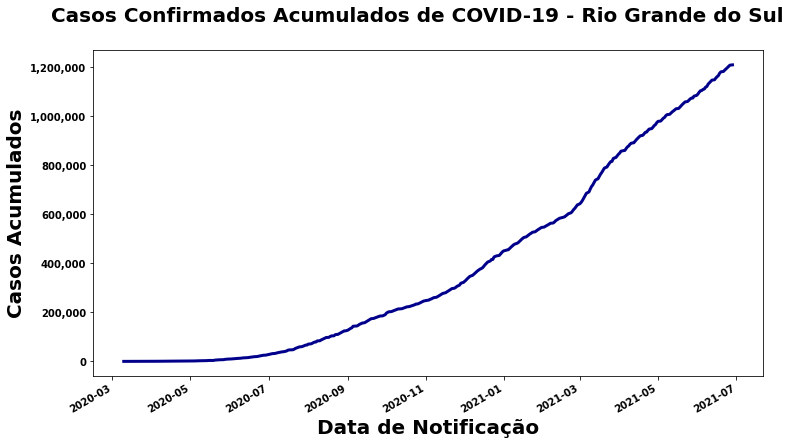

In [13]:
ax = sns.lineplot(data = dados_estado,
             x = 'date',
             y = 'last_available_confirmed',
             lw=3, color = 'darkblue')

plt.suptitle('Casos Confirmados Acumulados de COVID-19 - Rio Grande do Sul',
             fontsize=20, fontweight = 'bold')
plt.xlabel('Data de Notificação',
             fontsize=20, fontweight = 'bold')
plt.ylabel('Casos Acumulados',
             fontsize=20, fontweight = 'bold')
plt.xticks(rotation=30,ha='right')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

Podemos perceber que o crescimento da quantidade de casos não parece se dar de forma linear e sim exponencial.

Vamos verificar como é a distribuição desses casos nos 497 municípios do estado, separando em *clusters* de acordo com a população estimada.

**OBS.:** A população estimada utilizada em todo o *dataset* é a projeção feita pelo IBGE para o ano de 2020.

In [14]:
lista_clusters = ['(0.0, 50000.0]','(50000.0, 100000.0]',
                  '(100000.0, 200000.0]', '(200000.0, 500000.0]',
                  '(500000.0, 50000000.0]']
                  
for k in range(5):
    exec(f"df_temp_{k} = dados_munic[(dados_munic['cluster_munic'] == lista_clusters[{k}])]")

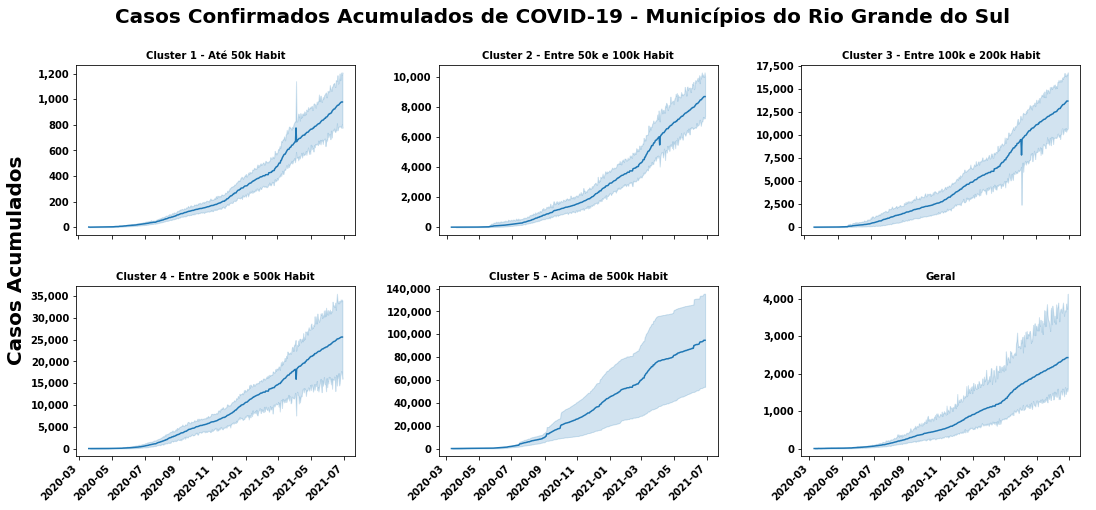

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,8), sharex=False)
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')

num_df = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            exec(f"sns.lineplot(data = dados_munic, ci = 100, ax = ax[{i},{j}], x = 'date', y = 'last_available_confirmed')")
        else:
            exec(f"sns.lineplot(data = df_temp_{num_df}, ci = 100, ax = ax[{i},{j}], x = 'date', y = 'last_available_confirmed')")
        num_df = num_df + 1

plt.suptitle('Casos Confirmados Acumulados de COVID-19 - Municípios do Rio Grande do Sul',
             fontsize=20, fontweight = 'bold')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Casos Acumulados', labelpad = 25,
           fontsize=20, fontweight = 'bold')

for i in range(0,2):
    for j in range(0,3):
        ax[i,j].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')


ax[0,0].set_title('Cluster 1 - Até 50k Habit', fontsize=10, fontweight='bold')
ax[0,1].set_title('Cluster 2 - Entre 50k e 100k Habit', fontsize=10, fontweight='bold')
ax[0,2].set_title('Cluster 3 - Entre 100k e 200k Habit', fontsize=10, fontweight='bold')
ax[1,0].set_title('Cluster 4 - Entre 200k e 500k Habit', fontsize=10, fontweight='bold')
ax[1,1].set_title('Cluster 5 - Acima de 500k Habit', fontsize=10, fontweight='bold')
ax[1,2].set_title('Geral', fontsize=10, fontweight='bold')

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

A área azul mais clara representa os dados de todos os municípios do *cluster*, com intervalo de confiança de 100%. A linha azul mais escura nos traz a média.

Os gráficos apresentam escalas diferentes nos seus eixos **Y** para comportar os diferentes tamanhos de municípios, mas como era de se esperar, as curvas traçada para as médias de cada *cluster* são muito semelhantes à curva do estado inteiro.

Podemos perceber que em todos os *clusters* o crescimento de casos vem ocorrendo de uma forma não-linear. A **HIPÓTESE** é de que esse crescimento seja exponencial, mas isso precisa ser confirmado.

Para prosseguir em nossa análise, vamos analisar os dados de forma dividida, olhando o estado como um todo (consolidado), somente Porto Alegre e somente os municípios do Interior.

Para confirmar o crescimento exponencial, vamos colocar o eixo **Y** em escala logarítmica .



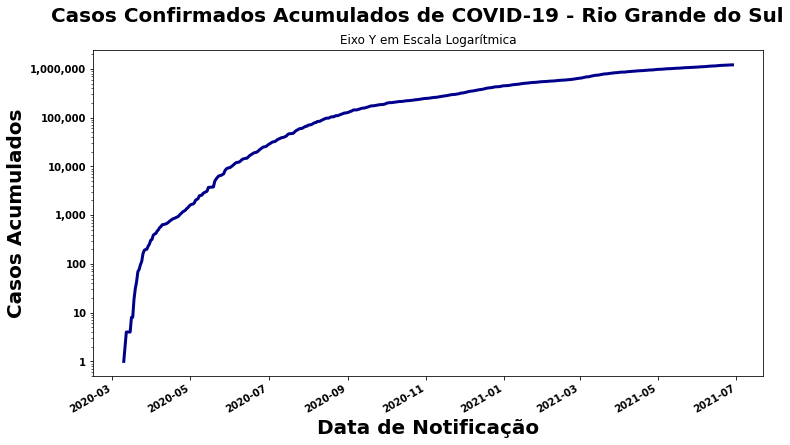

In [16]:
ax = sns.lineplot(data = dados_estado,
             x = 'date',
             y = 'last_available_confirmed',
             lw=3, color = 'darkblue')
mpl.pyplot.yscale('log')
plt.suptitle('Casos Confirmados Acumulados de COVID-19 - Rio Grande do Sul',
             fontsize=20, fontweight = 'bold')
plt.title('Eixo Y em Escala Logarítmica')
plt.xlabel('Data de Notificação',
             fontsize=20, fontweight = 'bold')
plt.ylabel('Casos Acumulados',
             fontsize=20, fontweight = 'bold')
plt.xticks(rotation=30,ha='right')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

Temos a confirmação de que o crescimento de casos se deu de forma exponencial, com pelo menos 3 diferentes segmentos de reta de inclinações diferentes.

Isso significa que tivemos mudanças na taxa de crescimento a cada alteração de inclinação da reta.

<img src='https://drive.google.com/uc?id=1dZVBNXAHUFdLtIH4Msf6R-eNOD1cfMtD'>

Vamos confirmar se a curva para a cidade de Porto Alegre é semelhante.

In [17]:
dados_poa = dados_munic.query('city == "Porto Alegre"')
dados_interior = dados_munic.query('city != "Porto Alegre"').groupby(by='date').sum().reset_index()

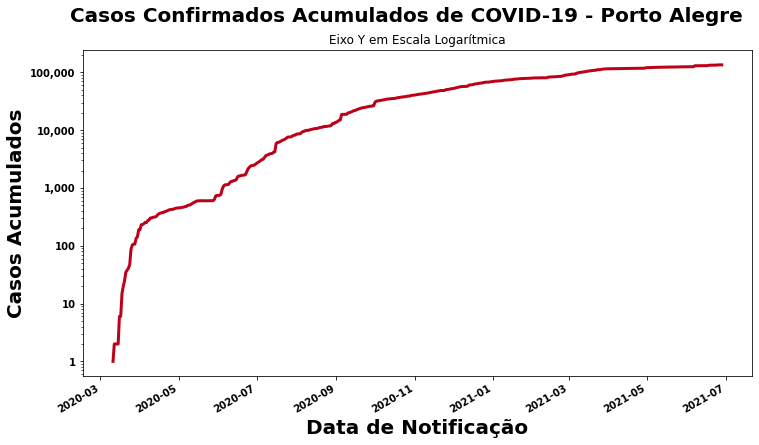

In [18]:
ax = sns.lineplot(data = dados_poa,
             x = 'date',
             y = 'last_available_confirmed',
             lw=3, color = 'xkcd:scarlet')
mpl.pyplot.yscale('log')
plt.suptitle('Casos Confirmados Acumulados de COVID-19 - Porto Alegre',
             fontsize=20, fontweight = 'bold')
plt.title('Eixo Y em Escala Logarítmica')
plt.xlabel('Data de Notificação',
             fontsize=20, fontweight = 'bold')
plt.ylabel('Casos Acumulados',
             fontsize=20, fontweight = 'bold')
plt.xticks(rotation=30,ha='right')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

É interessante observar que Porto Alegre também apresenta uma curva de crescimento exponencial que pode ser dividida em 3 períodos (ou retas) como na imagem abaixo.

A fase inicial (em vermelho), mais aguda, com rápida disseminação, durando 30 a 45 dias. Depois tivemos medidas de restrição da circulação das pessoas, reduzindo a velocidade de contágio, com duração em torno de 180 dias. Por último, a fase de crescimento com menor inclinação, que dura até hoje.

<img src='https://drive.google.com/uc?id=1etwYu2yY4kgNsWV9vuCGkxFUaAyLnPqN'>

Percebe-se, no entanto, que o período intermediário parece ser um pouco mais extenso do que no gráfico do RS inteiro, além de apresentar algumas variações na curva que está por baixo.

Vamos passar a analisar o comportamento do surgimento de casos novos que formaram essa curva de casos acumulados.


## **Surgimento de Casos Novos**
---

Vamos agora olhar os dados referentes ao surgimento de casos novos. Para já conseguir uma comparação e análise inicial, vamos colocar lado a lado os dados do estado inteiro, só de Porto Alegre e do somatório dos municípios do interior.

Para facilitar a visualização e suavizar um pouco o gráfico, também vamos incluir uma média móvel de 7 dias.

In [19]:
dados_estado['MM7 Casos Novos'] = dados_estado['new_confirmed'].rolling(window = 7,
                                                                       center = False).mean()
dados_poa['MM7 Casos Novos'] = dados_poa['new_confirmed'].rolling(window = 7,
                                                                       center = False).mean()
dados_interior['MM7 Casos Novos'] = dados_interior['new_confirmed'].rolling(window = 7,
                                                                       center = False).mean()

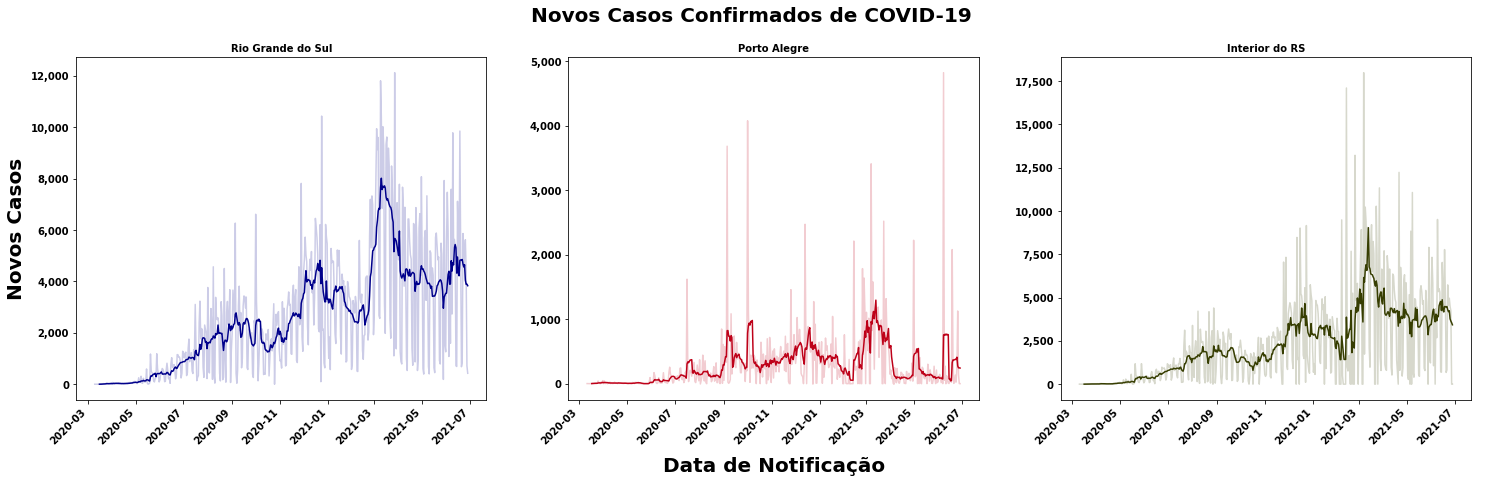

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')
plt.suptitle('Novos Casos Confirmados de COVID-19',
             fontsize=20, fontweight = 'bold')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Data de Notificação', labelpad = 40,
           fontsize=20, fontweight = 'bold')
plt.ylabel('Novos Casos', labelpad = 25,
           fontsize=20, fontweight = 'bold')

ax[0].set_title('Rio Grande do Sul', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_estado, x = 'date', y = 'new_confirmed',
                  color = 'darkblue', alpha= 0.20, ax = ax[0])
sns.lineplot(data = dados_estado, x = 'date', y = 'MM7 Casos Novos',
             color = 'darkblue', ax = ax[0])

ax[1].set_title('Porto Alegre', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_poa, x = 'date', y = 'new_confirmed',
                  color = 'xkcd:scarlet', alpha= 0.20, ax = ax[1])
sns.lineplot(data = dados_poa, x = 'date', y = 'MM7 Casos Novos',
             color = 'xkcd:scarlet', ax = ax[1])

ax[2].set_title('Interior do RS', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_interior, x = 'date', y = 'new_confirmed',
                  color = 'xkcd:dark olive', alpha= 0.20, ax = ax[2])
sns.lineplot(data = dados_interior, x = 'date', y = 'MM7 Casos Novos',
             color = 'xkcd:dark olive', ax = ax[2])

for j in range(0,3):
    ax[j].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax[j].set_ylabel('')
    ax[j].set_xlabel('')

Como o lançamento do dado depende sempre da notificação feita pelos municípios para a Secretaria Estadual de Saúde, é possível notar que a curva diária fica bem errática, tendo dias de fortes picos antecedidos e seguidos por dias com baixas notificações.

Isso provavelmente indica algum tipo de represamento de informações.

Outro ponto interessante a ser observado é que os dados do estado inteiro não é resultante do somatório dos municípios, pois tivemos o maior pico diário do estado por volta de 12 mil casos enquanto que somente na soma dos municípios do interior ultrapassamos essa marca em pelo menos 3 datas, chegando a um pico de mais de 17,5 mil casos em março de 2021.

Tanto no gráfico do estado inteiro quanto no gráfico do interior, podemos perceber uma tendência de alta no surgimento de casos, que funciona em ondas, com fundos e topos ascendentes, sendo que as ondas maiores são formadas por ondas menores, de maneira muito semelhante a fractais. Já em Porto Alegre a tendência é mais errática, sem deixar clara a alta, alternando topos mais altos e mais baixos com fundos num nível semelhante.

Essa tendência errática de Porto Alegre nos mostra uma concentração ainda maior de lançamento de notificações em dias específicos, reforçando a ideia de represamento de informações.

Precisamos tomar cuidado com as avaliações feitas, pois essa concentração de lançamentos gera *outliers* que prejudicam uma série de possíveis análises de sazonalidade, correlação com óbitos e com datas específicas em que medidas de contenção foram tomadas.



### **(Nem Tão)Breve Intervalo** - Avaliação do Dia de Pico de Casos Novos
---

Para tentar entender como o pico diário da soma dos municípios era maior que o pico diário do estado inteiro e confirmar se não houve algum erro meu na criação desse *dataset* de somatório, resolvi fazer algumas buscas nos dados e encontrei alguns pontos que resolvi destacar.

In [21]:
maximo = dados_interior.new_confirmed.max()
minimo = dados_interior.new_confirmed.min()
dados_interior.query('new_confirmed == @maximo | new_confirmed == @minimo')[['new_confirmed']]

new_confirmed
68              -4
362          17990

Ao investigar as datas em que ocorreram os valores mínimos e máximos de casos novos no somatório dos municípios do interior, percebe-se que tivemos 4 casos negativos no dia 17/mai/20, indicando uma correção de informações anteriores. E o valor máximo foi encontrado em 07/mar/21, com os 17990 casos que havíamos visto no gráfico.

In [22]:
dados_rs.query('city == "Porto Alegre" | city_ibge_code == 43').query('date == "2020-05-17" | date == "2021-03-07"')[['date','city','new_confirmed']]

date          city  new_confirmed
indice                                         
1645792 2020-05-17  Porto Alegre              5
1645876 2020-05-17           NaN              1
1782791 2021-03-07  Porto Alegre           3407
1782967 2021-03-07           NaN           2671

Ao avaliar essas mesmas datas nos *datasets* de Porto Alegre e do estado consolidado, temos:
* **17/mai/20:** Porto Alegre apresentou 5 casos que, com os 4 casos negativos do interior, totalizam o único caso que aparece no consolidado. Aparentemente a informação está correta
* **07/mar/21:** Porto Alegre apresentou 3407 casos que, somados aos 17990 casos dos municípios do interior deveria totalizar 21397 casos, mas o consolidado apresenta apenas 2671 casos. Aí temos um erro significativo

In [23]:
maximo = dados_poa.new_confirmed.max()
minimo = dados_poa.new_confirmed.min()
dados_poa.query('new_confirmed == @maximo | new_confirmed == @minimo')[['date','new_confirmed']]

date  new_confirmed
indice                           
1797262 2021-04-05             -9
1828699 2021-06-07           4820

Analisando o *dataset* de Porto Alegre podemos confirmar a informação do gráfico de que o máximo de casos em um único dia foi próximo de 5 mil casos e ver que também tivemos valores abaixo de zero, indicando correção de dados anteriores.

In [24]:
maximo = dados_estado.new_confirmed.max()
minimo = dados_estado.new_confirmed.min()
dados_estado.query('new_confirmed == @maximo | new_confirmed == @minimo')[['date','new_confirmed']]

date  new_confirmed
indice                           
1639376 2020-03-13              0
1639380 2020-03-14              0
1639384 2020-03-15              0
1639392 2020-03-17              0
1716600 2020-10-25              0
1792947 2021-03-27          12122

Analisando os dados consolidados do estado, podemos ver que não tivemos nenhum dia negativo e, com uma exceção, os valores mínimos se referem aos dias iniciais da pandemia. Já o valor máximo fica próximo de 12 mil casos, conforme também vimos no gráfico.

Resolvi tentar verificar se essas ocorrências de estornos ocorriam de forma significativa na base, a ponto de poder gerar grandes distorções nos futuros modelos de previsão.

In [25]:
maximo = 1500
minimo = -150
dados_rs.query('city_ibge_code != 43 & city != "Porto Alegre"' 
               ).query('new_confirmed >= @maximo | new_confirmed <= @minimo' 
                       )[['date','city','estimated_population','new_confirmed','last_available_confirmed']].sort_values(by='city')

date  ... last_available_confirmed
indice              ...                         
1796800 2021-04-04  ...                      931
1797299 2021-04-05  ...                     5806
1796801 2021-04-04  ...                      392
1796803 2021-04-04  ...                    11841
1797302 2021-04-05  ...                      365
1796804 2021-04-04  ...                       51
1797303 2021-04-05  ...                    11841
1796805 2021-04-04  ...                    23326
1797304 2021-04-05  ...                       51
1796806 2021-04-04  ...                      500
1797305 2021-04-05  ...                    23323
1796807 2021-04-04  ...                     9527
1797306 2021-04-05  ...                      500
1796808 2021-04-04  ...                      179
1797307 2021-04-05  ...                     9527
1797308 2021-04-05  ...                      179
1796809 2021-04-04  ...                     1795
1797309 2021-04-05  ...                     1795
1796810 2021-04-04  ...                       69
1796811 2021-04-04  ...                     5807
1797310 2021-04-05  ...                       69

[21 rows x 5 columns]

Como podemos ver pelo resultado acima, tivemos uma grande quantidade de erros em 04/abr/2021 que foram revertidos no dia seguinte. Em alguns casos o lançamento era muito superior a própria população da cidade.

Para evitar distorções futuras, optei por criar uma função para "normalizar" esses dados, ou seja, alterei os dados dos dias 04 e 05/abr/2021 para que o número de casos novos fosse igual a média dos dois dias. Depois disso, corrigi os valores de casos acumulados desses dias também.


In [26]:
cidades_normalizar = dados_rs.query('city_ibge_code != 43 & city != "Porto Alegre"' 
               ).query('new_confirmed >= @maximo | new_confirmed <= @minimo' 
                       )['city'].unique()

cidades_normalizar

array(["Sant'Ana do Livramento", 'Santa Bárbara do Sul',
       'Santa Clara do Sul', 'Santa Cruz do Sul',
       'Santa Margarida do Sul', 'Santa Maria', 'Santa Maria do Herval',
       'Santa Rosa', 'Santa Tereza', 'Santa Vitória do Palmar',
       'Santana da Boa Vista'], dtype=object)

In [27]:
def normaliza(cidade):
    novos_04, acum_04 = dados_rs.query('date == "2021-04-04"').query('city == @cidade')[['new_confirmed','last_available_confirmed']].iloc[0]
    ind_04 = dados_rs.query('date == "2021-04-04"').query('city == @cidade')[['new_confirmed','last_available_confirmed']].index
    novos_05, acum_05 = dados_rs.query('date == "2021-04-05"').query('city == @cidade')[['new_confirmed','last_available_confirmed']].iloc[0]
    ind_05 = dados_rs.query('date == "2021-04-05"').query('city == @cidade')[['new_confirmed','last_available_confirmed']].index

    sub_04 = int(float(novos_04 + novos_05) / 2.0)
    sub_05 = novos_04 + novos_05 - sub_04
    sub_acum_04 = acum_04 - novos_04 + sub_04
    sub_acum_05 = sub_acum_04 + sub_05
    dados_rs.loc[ind_04,'new_confirmed'] = sub_04
    dados_rs.loc[ind_04,'last_available_confirmed'] = sub_acum_04
    dados_rs.loc[ind_05,'new_confirmed'] = sub_05
    dados_rs.loc[ind_05,'last_available_confirmed'] = sub_acum_05

In [28]:
for cidade in cidades_normalizar:
    normaliza(cidade)

Como essas alterações foram feitas no *DataFrame* ```dados_rs```, agora precisamos refazer os *DataFrames* que contém os dados separados entre capital e interior e recalcular as médias móveis.

In [29]:
dados_estado, dados_munic = separa (dados_rs)
dados_poa = dados_munic.query('city == "Porto Alegre"')
dados_interior = dados_munic.query('city != "Porto Alegre"').groupby(by='date').sum().reset_index()
dados_estado['MM7 Casos Novos'] = dados_estado['new_confirmed'].rolling(window = 7,
                                                                       center = False).mean()
dados_poa['MM7 Casos Novos'] = dados_poa['new_confirmed'].rolling(window = 7,
                                                                       center = False).mean()
dados_interior['MM7 Casos Novos'] = dados_interior['new_confirmed'].rolling(window = 7,
                                                                       center = False).mean()

Feito tudo isso, podemos retomar o estudo, passando agora a analisar os dados referentes aos óbitos ocorridos em decorrência do COVID-19.

## **Óbitos**
---


Apesar de Porto Alegre concentrar 13% da população do estado, a capital responde por algo em torno 11% dos casos. Temos uma taxa menor de contaminação na capital, de 9,1% (contra 10,8% no restante do estado).

No entanto, a epidemia tem se mostrado mais letal na capital do que no interior do estado. Enquanto 2,43% dos casos confirmados no interior do estado acabam em óbito do paciente, o índice em Porto Alegre atinge 3,76%.

Vamos visualizar os dados de óbitos e comparar o comportamento de Porto Alegre e do restante do estado.

In [30]:
dados_estado['MM7 Óbitos'] = dados_estado['new_deaths'].rolling(window = 7,
                                                                       center = False).mean()
dados_poa['MM7 Óbitos'] = dados_poa['new_deaths'].rolling(window = 7,
                                                                       center = False).mean()
dados_interior['MM7 Óbitos'] = dados_interior['new_deaths'].rolling(window = 7,
                                                                       center = False).mean()

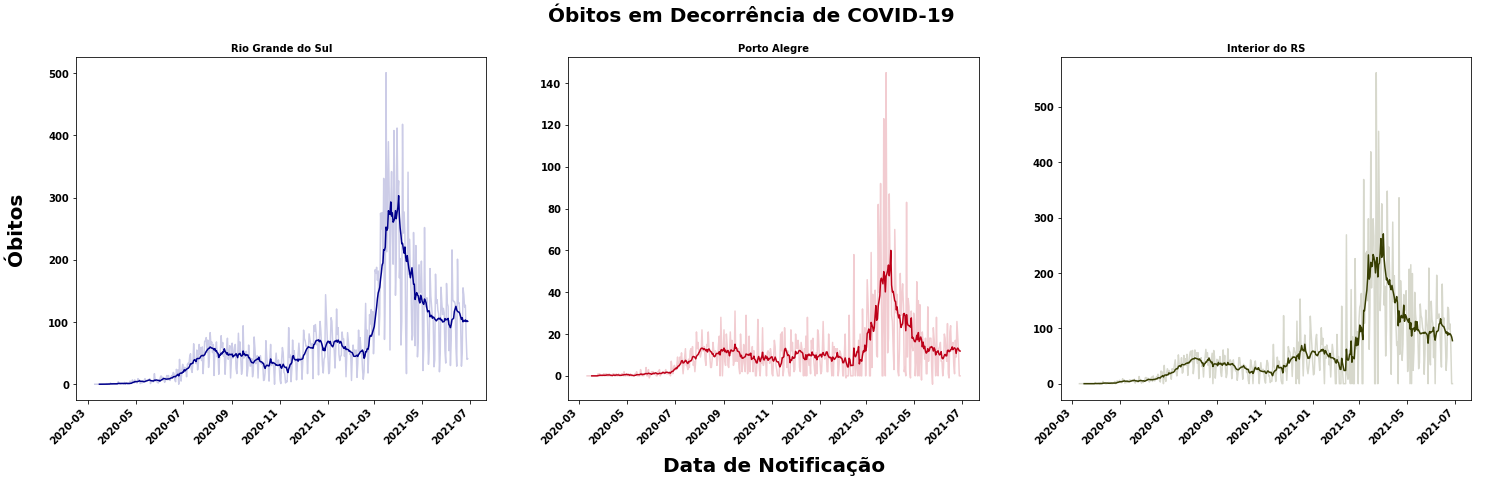

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')
plt.suptitle('Óbitos em Decorrência de COVID-19',
             fontsize=20, fontweight = 'bold')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Data de Notificação', labelpad = 40,
           fontsize=20, fontweight = 'bold')
plt.ylabel('Óbitos', labelpad = 25,
           fontsize=20, fontweight = 'bold')

ax[0].set_title('Rio Grande do Sul', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_estado, x = 'date', y = 'new_deaths',
                  color = 'darkblue', alpha= 0.20, ax = ax[0])
sns.lineplot(data = dados_estado, x = 'date', y = 'MM7 Óbitos',
             color = 'darkblue', ax = ax[0])

ax[1].set_title('Porto Alegre', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_poa, x = 'date', y = 'new_deaths',
                  color = 'xkcd:scarlet', alpha= 0.20, ax = ax[1])
sns.lineplot(data = dados_poa, x = 'date', y = 'MM7 Óbitos',
             color = 'xkcd:scarlet', ax = ax[1])

ax[2].set_title('Interior do RS', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_interior, x = 'date', y = 'new_deaths',
                  color = 'xkcd:dark olive', alpha= 0.20, ax = ax[2])
sns.lineplot(data = dados_interior, x = 'date', y = 'MM7 Óbitos',
             color = 'xkcd:dark olive', ax = ax[2])

for j in range(0,3):
    ax[j].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax[j].set_ylabel('')
    ax[j].set_xlabel('')

Mais uma vez podemos perceber um comportamento em ondas, mais claro no interior do RS do que em Porto Alegre.

Em Porto Alegre tivemos uma elevação de patamar no final de junho de 2020 que se manteve até aproximadamente a metade de fevereiro, sem grandes variações. A partir da 2ª quinzena de fevereiro tivemos uma forte escalada no número de óbitos, atingindo seu pico em meados de abril de 2021.

No interior do estado tivemos a mesma elevação no final de junho, mas a partir de agosto houve uma certa redução, fazendo nova elevação entre novembro e final de dezembro, para cair até a 2ª quinzena de fevereiro novamente. A partir daí houve então a mesma forte escalada que ocorreu em Porto Alegre, com o mesmo pico em meados de abril de 2021.

Nos números consolidados do RS e do Interior do RS, podemos notar uma semelhança entre as ondas de aumento de casos e de óbitos. Vamos passar a verificar a correlação entre essas duas variáveis.

### **Existe Correlação Entre Casos Novos e Óbitos?**
---

agfasdg
asg
a
dg
asd
gfa
sd
fga
dgf
asd
gfa
sdf
ad
fas
df


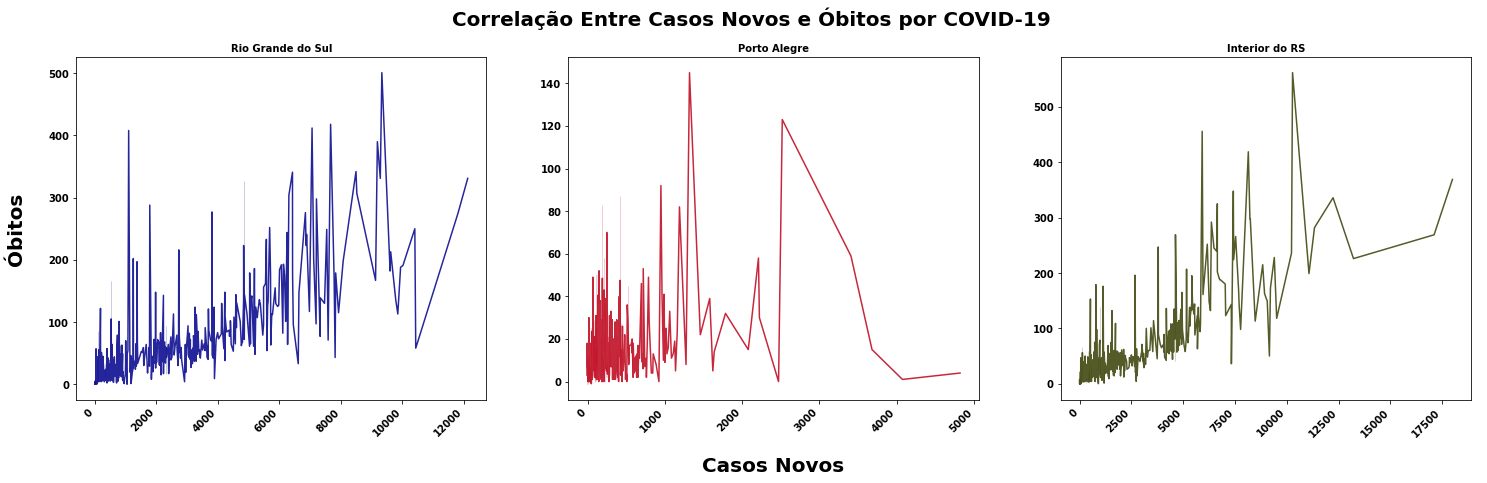

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')
plt.suptitle('Correlação Entre Casos Novos e Óbitos por COVID-19',
             fontsize=20, fontweight = 'bold')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Casos Novos', labelpad = 40,
           fontsize=20, fontweight = 'bold')
plt.ylabel('Óbitos', labelpad = 25,
           fontsize=20, fontweight = 'bold')

ax[0].set_title('Rio Grande do Sul', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_estado, x = 'new_confirmed', y = 'new_deaths',
                  color = 'darkblue', alpha= 0.85, ax = ax[0])
#sns.lineplot(data = dados_estado, x = 'date', y = 'MM7 Óbitos',
#             color = 'tomato', ax = ax[0])

ax[1].set_title('Porto Alegre', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_poa, x = 'new_confirmed', y = 'new_deaths',
                  color = 'xkcd:scarlet', alpha= 0.85, ax = ax[1])
#sns.lineplot(data = dados_poa, x = 'date', y = 'MM7 Óbitos',
#             color = 'tomato', ax = ax[1])

ax[2].set_title('Interior do RS', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_interior, x = 'new_confirmed', y = 'new_deaths',
                  color = 'xkcd:dark olive', alpha= 0.85, ax = ax[2])
#sns.lineplot(data = dados_interior, x = 'date', y = 'MM7 Óbitos',
#             color = 'tomato', ax = ax[2])

for j in range(0,3):
    ax[j].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax[j].set_ylabel('')
    ax[j].set_xlabel('')

Parece que os dados consolidados do RS e do Interior até apresentam uma correlação inicial que se perde com o aumento do número de casos. Mas sabemos que os óbitos só ocorrem alguns dias depois da notificação dos casos.

Para testar se existe uma correlação mais forte, vamos retroceder os óbitos em 7 e 14 dias para comparar com os casos novos correspondentes.

In [33]:
for k in [-7,-14]:
    exec(f"dados_estado['Óbitos {k}'] = dados_estado['new_deaths'].shift({k})")
    exec(f"dados_poa['Óbitos {k}'] = dados_poa['new_deaths'].shift({k})")
    exec(f"dados_interior['Óbitos {k}'] = dados_interior['new_deaths'].shift({k})")


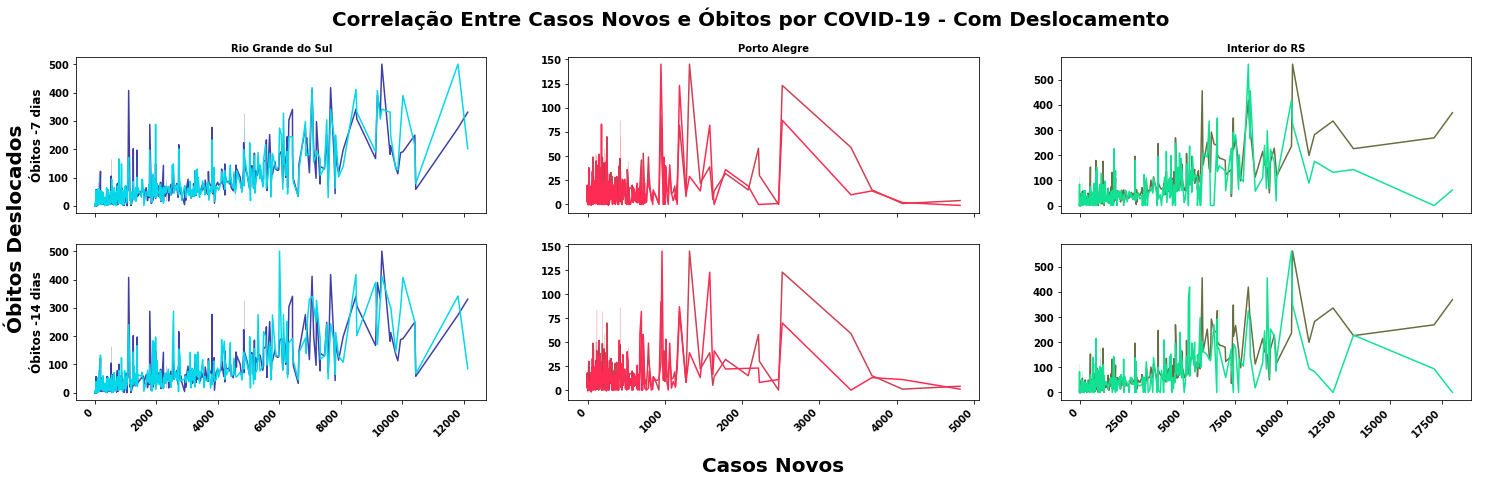

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (25,7))
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')
plt.suptitle('Correlação Entre Casos Novos e Óbitos por COVID-19 - Com Deslocamento',
             fontsize=20, fontweight = 'bold')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Casos Novos', labelpad = 40,
           fontsize=20, fontweight = 'bold')
plt.ylabel('Óbitos Deslocados', labelpad = 25,
           fontsize=20, fontweight = 'bold')

ax[0,0].set_title('Rio Grande do Sul', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_estado, x = 'new_confirmed', y = 'new_deaths',
                  color = 'darkblue', alpha= 0.75, ax = ax[0,0])
sns.lineplot(data = dados_estado, x = 'new_confirmed', y = 'Óbitos -7',
             color = 'xkcd:aqua blue', ax = ax[0,0])
sns.lineplot(data = dados_estado, x = 'new_confirmed', y = 'new_deaths',
                  color = 'darkblue', alpha= 0.75, ax = ax[1,0])
sns.lineplot(data = dados_estado, x = 'new_confirmed', y = 'Óbitos -14',
             color = 'xkcd:aqua blue', ax = ax[1,0])

ax[0,1].set_title('Porto Alegre', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_poa, x = 'new_confirmed', y = 'new_deaths',
                  color = 'xkcd:scarlet', alpha= 0.75, ax = ax[0,1])
sns.lineplot(data = dados_poa, x = 'new_confirmed', y = 'Óbitos -7',
             color = 'xkcd:reddish pink', ax = ax[0,1])
sns.lineplot(data = dados_poa, x = 'new_confirmed', y = 'new_deaths',
                  color = 'xkcd:scarlet', alpha= 0.75, ax = ax[1,1])
sns.lineplot(data = dados_poa, x = 'new_confirmed', y = 'Óbitos -14',
             color = 'xkcd:reddish pink', ax = ax[1,1])

ax[0,2].set_title('Interior do RS', fontsize=10, fontweight='bold')
sns.lineplot(data = dados_interior, x = 'new_confirmed', y = 'new_deaths',
                  color = 'xkcd:dark olive', alpha= 0.75, ax = ax[0,2])
sns.lineplot(data = dados_interior, x = 'new_confirmed', y = 'Óbitos -7',
             color = 'xkcd:aqua green', ax = ax[0,2])
sns.lineplot(data = dados_interior, x = 'new_confirmed', y = 'new_deaths',
                  color = 'xkcd:dark olive', alpha= 0.75, ax = ax[1,2])
sns.lineplot(data = dados_interior, x = 'new_confirmed', y = 'Óbitos -14',
             color = 'xkcd:aqua green', ax = ax[1,2])

for i in range(0,2):
    for j in range(0,3):
        ax[i,j].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')

ax[0,0].set_ylabel('Óbitos -7 dias', fontsize=12, fontweight='bold')
ax[1,0].set_ylabel('Óbitos -14 dias', fontsize=12, fontweight='bold')
plt.show()

Não consegui perceber grande variação na correlação, mesmo com as variações de período propostas. Para uma última confirmação, vamos testar matematicamente qual seria o deslocamento que traria a melhor correlação entre essas duas variáveis, nos diferentes *datasets*.

In [35]:
def verif_correl(df):
    i_maior_correl = 0
    maior_correl = 0
    i_menor_correl = 0
    menor_correl = 1

    for i in list(range(0,int(df.shape[0]/2),1)):
        df_temp = pd.DataFrame()
        df_temp['casos'] = df['new_confirmed']
        df_temp['obitos_desloc'] = df['new_deaths'].shift(-i)
        df_temp.dropna(inplace=True)
        correl = np.corrcoef(df_temp['casos'],df_temp['obitos_desloc'])
        if correl[0,1] > maior_correl:
            maior_correl = correl[0,1]
            i_maior_correl = i
        elif correl[0,1] < menor_correl:
            menor_correl = correl[0,1]
            i_menor_correl = i

    return(i_maior_correl,maior_correl,i_menor_correl,menor_correl)


In [36]:
i_maior_correl,maior_correl,i_menor_correl,menor_correl = verif_correl(dados_estado)
print('Rio Grande do Sul')
print('Maior -->',i_maior_correl,' - ',maior_correl)
print('Menor -->',i_menor_correl,' - ',menor_correl)

print('\nPorto Alegre')
i_maior_correl,maior_correl,i_menor_correl,menor_correl = verif_correl(dados_poa)
print('Maior -->',i_maior_correl,' - ',maior_correl)
print('Menor -->',i_menor_correl,' - ',menor_correl)

print('\nInterior do RS')
i_maior_correl,maior_correl,i_menor_correl,menor_correl = verif_correl(dados_interior)
print('Maior -->',i_maior_correl,' - ',maior_correl)
print('Menor -->',i_menor_correl,' - ',menor_correl)

Rio Grande do Sul
Maior --> 7  -  0.7720170745967265
Menor --> 156  -  0.12364353026656863

Porto Alegre
Maior --> 202  -  0.4483335218769933
Menor --> 235  -  -0.03013719127216712

Interior do RS
Maior --> 0  -  0.8121719808707851
Menor --> 184  -  0.04584954142508189


O resultado dessa função confirma o que havíamos suspeitado graficamente.

Tanto o RS Consolidado como somente o Interior apresentam uma correlação relativamente alta se trabalharmos com 7 dias de deslocamento ou nenhum dia, respectivamente.

Já Porto Alegre apresenta uma correlação bem mais fraca, sendo que o maior valor encontrado foi para um deslocamento de 202 dias, o que particularmente não faz nenhum sentido.

## **Investigando a Sazonalidade**
---

Vamos aproveitar que investigamos a correlação entre os casos novos e os óbitos fazendo o deslocamento da série de óbitos e verificar a existência de sazonalidade, através da verificação da correlação dos dados com eles mesmos, usando diferentes deslocamentos (ou *lags*).

Dessa vez vamos fazer o contrário, investigando primeiro matematicamente, através de uma função, para depois fazer a análise gráfica.

### **Primeiro, Matematicamente...**

In [37]:
def verif_autocorrel(df):
    i_maior_correl_casos = 0
    maior_correl_casos = 0
    i_maior_correl_obitos = 0
    maior_correl_obitos = 0

    for i in list(range(1,int(df.shape[0]/2),1)):
        df_temp = pd.DataFrame()
        df_temp['casos'] = df['new_confirmed']
        df_temp['casos_desloc'] = df['new_confirmed'].shift(-i)
        df_temp['obitos'] = df['new_deaths']
        df_temp['obitos_desloc'] = df['new_deaths'].shift(-i)
        df_temp.dropna(inplace=True)
        correl = np.corrcoef(df_temp['casos'],df_temp['casos_desloc'])
        if correl[0,1] > maior_correl_casos:
            maior_correl_casos = correl[0,1]
            i_maior_correl_casos = i
        correl2 = np.corrcoef(df_temp['obitos'],df_temp['obitos_desloc'])
        if correl2[0,1] > maior_correl_obitos:
            maior_correl_obitos = correl2[0,1]
            i_maior_correl_obitos = i

    return(i_maior_correl_casos,maior_correl_casos,i_maior_correl_obitos,maior_correl_obitos)


In [38]:
i_maior_correl_casos,maior_correl_casos,i_maior_correl_obitos,maior_correl_obitos = verif_autocorrel(dados_estado)
print('Rio Grande do Sul')
print('Casos  -->',i_maior_correl_casos,' - ',maior_correl_casos)
print('Óbitos -->',i_maior_correl_obitos,' - ',maior_correl_obitos)

print('\nPorto Alegre')
i_maior_correl_casos,maior_correl_casos,i_maior_correl_obitos,maior_correl_obitos = verif_autocorrel(dados_poa)
print('Casos -->',i_maior_correl_casos,' - ',maior_correl_casos)
print('Óbitos -->',i_maior_correl_obitos,' - ',maior_correl_obitos)

print('\nInterior do RS')
i_maior_correl_casos,maior_correl_casos,i_maior_correl_obitos,maior_correl_obitos = verif_autocorrel(dados_interior)
print('Casos -->',i_maior_correl_casos,' - ',maior_correl_casos)
print('Óbitos -->',i_maior_correl_obitos,' - ',maior_correl_obitos)

Rio Grande do Sul
Casos  --> 7  -  0.7937822706257953
Óbitos --> 7  -  0.8865128282580094

Porto Alegre
Casos --> 11  -  0.2828680435506016
Óbitos --> 7  -  0.6096458839464525

Interior do RS
Casos --> 14  -  0.5020045735028591
Óbitos --> 7  -  0.6553292821878753


Dessa vez podemos perceber uma correlação mais forte, principalmente de óbitos, com a periodicidade semanal (7 dias). Em relação aos casos novos, só podemos perceber esse comportamento quando olhamos o estado consolidado.

Acredito que isso esteja profundamente relacionado à maneira com que o Governo Estadual tratou as medidas restritivas de circulação da população, usando dos indicadores de casos e óbitos para restringir mais ou menos a livre circulação.

Conforme já vimos anteriormente, há indícios de que em diversos momentos houve represamento de informações, talvez para não piorar os indicadores, o que implicaria em fechamento do comércio, redução de horários de funcionamento de empresas, restrições de transporte público, etc.

Vamos verificar graficamente essas autocorrelações.

### **Agora, Graficamente!**

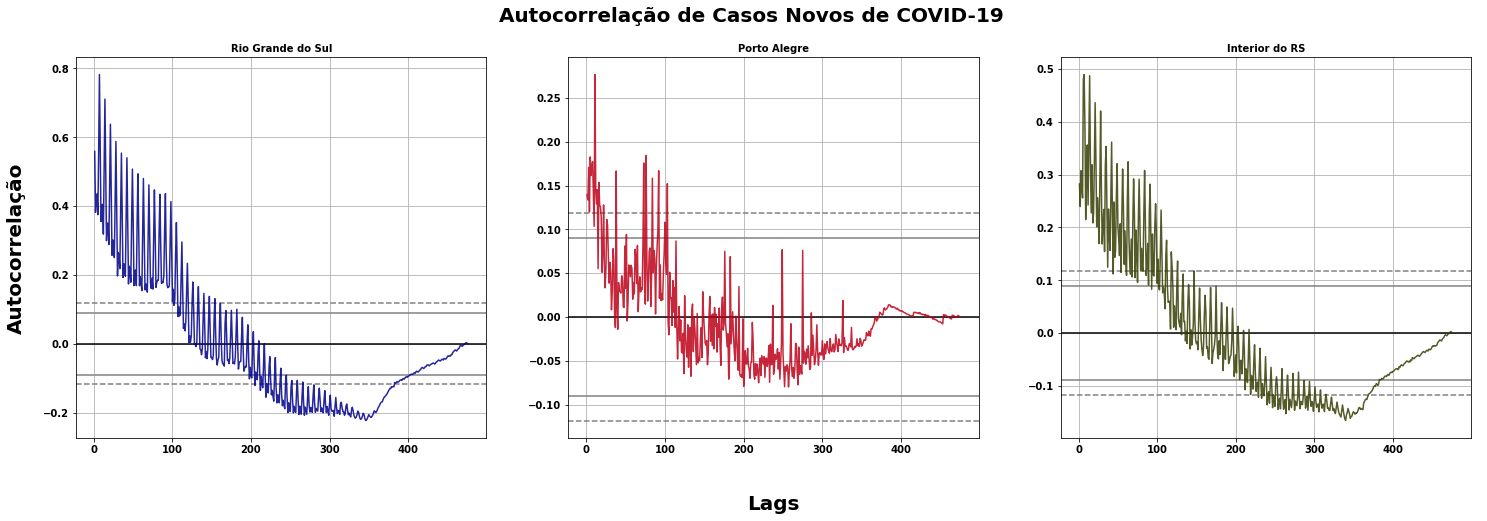

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))

plt.suptitle('Autocorrelação de Casos Novos de COVID-19',
             fontsize=20, fontweight = 'bold')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Lags', labelpad = 40,
           fontsize=20, fontweight = 'bold')
plt.ylabel('Autocorrelação', labelpad = 25,
           fontsize=20, fontweight = 'bold')

ax[0].set_title('Rio Grande do Sul', fontsize=10, fontweight='bold')
autocorrelation_plot(dados_estado['new_confirmed'],
                  color = 'darkblue', alpha= 0.85, ax = ax[0])

ax[1].set_title('Porto Alegre', fontsize=10, fontweight='bold')
autocorrelation_plot(dados_poa['new_confirmed'],
                  color = 'xkcd:scarlet', alpha= 0.85, ax = ax[1])

ax[2].set_title('Interior do RS', fontsize=10, fontweight='bold')
autocorrelation_plot(dados_interior['new_confirmed'],
                  color = 'xkcd:dark olive', alpha= 0.85, ax = ax[2])

for j in range(0,3):
    ax[j].set_ylabel('')
    ax[j].set_xlabel('')

Podemos verificar que a correlação se apresenta mais forte com pequenos deslocamentos, indicando uma sazonalidade curta, semanal. Para todos os nossos *datasets* temos uma queda forte da correlação à medida que aumentamos os deslocamentos, indicando uma falta de correlação para períodos maiores, muito provavelmente por estarmos tratando de uma doença nova que ainda não teve a oportunidade de passar por ciclos mais longos como o anual, por exemplo.

Chama a atenção a fraquíssima autocorrelação apresentada pelos dados de Porto Alegre, até mesmo para períodos curtos. Isso provavelmente vai impactar em nosso modelo preditivo mais adiante. Mas esse é mais um ponto em que o comportamento da capital difere significativamente do interior do estado.

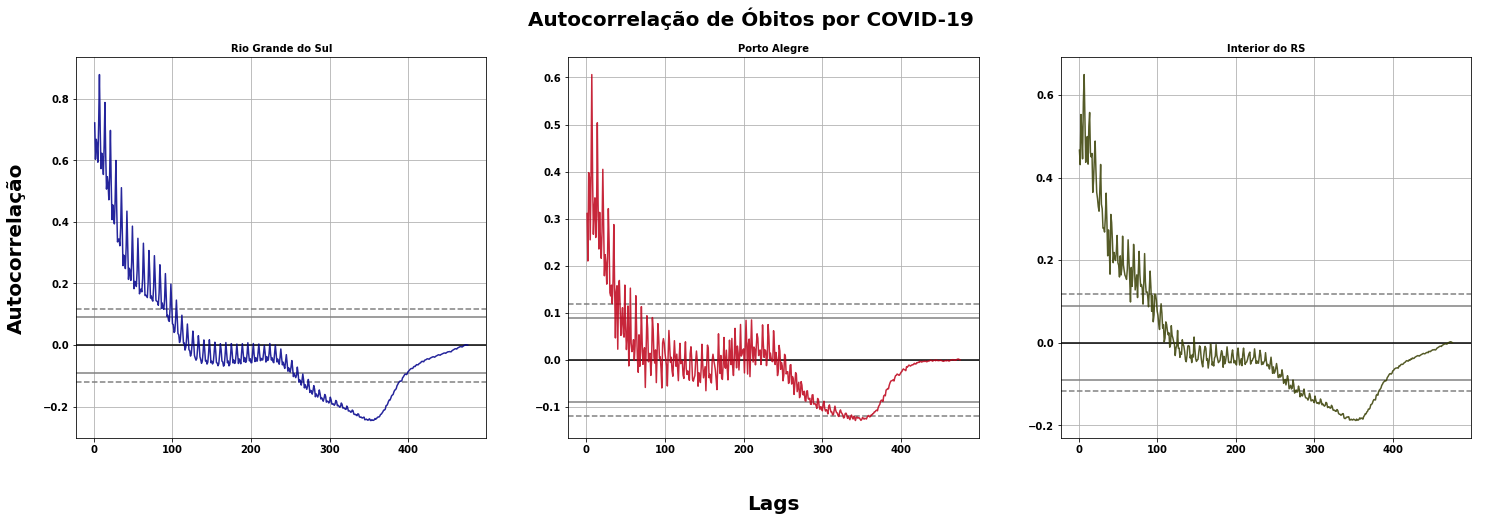

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))

plt.suptitle('Autocorrelação de Óbitos por COVID-19',
             fontsize=20, fontweight = 'bold')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Lags', labelpad = 40,
           fontsize=20, fontweight = 'bold')
plt.ylabel('Autocorrelação', labelpad = 25,
           fontsize=20, fontweight = 'bold')

ax[0].set_title('Rio Grande do Sul', fontsize=10, fontweight='bold')
autocorrelation_plot(dados_estado['new_deaths'],
                  color = 'darkblue', alpha= 0.85, ax = ax[0])

ax[1].set_title('Porto Alegre', fontsize=10, fontweight='bold')
autocorrelation_plot(dados_poa['new_deaths'],
                  color = 'xkcd:scarlet', alpha= 0.85, ax = ax[1])

ax[2].set_title('Interior do RS', fontsize=10, fontweight='bold')
autocorrelation_plot(dados_interior['new_deaths'],
                  color = 'xkcd:dark olive', alpha= 0.85, ax = ax[2])

for j in range(0,3):
    ax[j].set_ylabel('')
    ax[j].set_xlabel('')

Ao analisarmos a autocorrelação dos dados de óbitos, percebemos o mesmo comportamento de maior força nos pequenos deslocamentos com uma queda rápida em seguida.

No caso específico dos óbitos o comportamento de Porto Alegre é bem semelhante ao do interior, mesmo que apontando para uma autocorrelação de força média nos *lags* iniciais.

## **Elaborando um Modelo Preditivo**
---

Para poder fazer previsões precisamos elaborar um modelo preditivo que será treinado com parte dos nossos dados. Em seguida, esse modelo é testado com o restante do *dataset* para verificar sua acurácia.

Além disso, também usaremos ferramentas de validação cruzada para tentar identificar qual o horizonte de previsão que o nosso modelo vai conseguir trabalhar.

A biblioteca que usaremos para isso é a **Facebook Prophet**.

O **Prophet** é uma biblioteca criada pela divisão de pesquisa do **Facebook** e lançada em fevereiro de 2017.

É uma ferramenta *Open Source* (de código aberto, [link](https://github.com/facebook/prophet)) específica para previsões de séries temporais e está disponível para ***Python*** e ***R***, outra linguagem também muito usada para ciência de dados.

Tem uma sintaxe muito simples e intuitiva, sem por isso ser menos poderosa.

Vamos importá-la para o nosso projeto, junto com as métricas de avaliação da qualidade do modelo do próprio **Prophet** e de uma outra biblioteca, a **SciKitLearn**.

In [41]:
from fbprophet import Prophet

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

Para podermos usar o **Prophet** em nosso estudo, precisamos deixar os dados padronizados, como a ferramenta espera recebê-los.

Além disso, pretendemos gerar diversos modelos e testar a qualidade do resultado, tanto em relação aos dados de treino quanto em relação à previsão que será realizada.

Um dos parâmetros que iremos testar é o tipo de crescimento, que pode ser logístico ou linear (que é o *default*).

O *input* esperado pelo **Prophet** é na forma de um *DataFrame* de duas ou quatro colunas, de acordo com o tipo de crescimento, que pode ser logístico ou linear (que é o *default*). As colunas são:
* **```ds```** onde teremos a série temporal (vamos usar as datas que temos)
* **```y```** onde teremos a série de dados que temos e que iremos prever (vamos usar os casos novos e os óbitos em *dataframes* diferentes)
* **```cap```** (só para o modelo logístico) onde teremos o máximo que nossa previsão pode atingir (vamos usar a população estimada para isso)
* **```floor```** (só para o modelo logístico) onde teremos o mínimo que a previsão pode atingir (vamos usar ZERO para evitar valores negativos)

Vamos gerar os *DataFrames* esperados para nossos 3 *datasets* variando diversos parâmentros. Para isso vamos elaborar algumas funções que irão facilitar esse trabalho, jogando os resultados das métricas para um *DataFrame* de performance que depois iremos analisar para encontrar o melhor modelo gerado.

Outra informação necessária é a relação de feriados, pois isso pode impactar na transmissão e na notificação dos casos e óbitos. Vamos passar a lista de feriados do estado na forma de um *DataFrame*.

In [89]:
feriados = ['2020-01-01','2020-02-02','2020-02-24','2020-02-25','2020-02-26',
            '2020-04-09','2020-04-10','2020-04-21','2020-05-01','2020-06-11',
            '2020-09-07','2020-09-20','2020-10-12','2020-11-02','2020-11-15',
            '2020-12-24','2020-12-25','2020-12-31','2021-01-01','2021-02-02',
            '2021-02-15','2021-02-16','2021-02-17','2021-04-01','2021-04-02',
            '2021-04-21','2021-05-01','2021-06-03','2021-09-07','2021-09-20',
            '2021-10-12','2021-11-02','2021-11-15','2021-12-24','2021-12-25',
            '2021-12-31']
feriados = pd.DataFrame({'holiday': 'feriado', 'ds': pd.to_datetime(feriados)})

In [90]:
lista_colunas = ['df_usado','cps','var','cpr','n_cp','season','growth','dias_treino','dias_teste',
                 'evs','mae','mse','msle','mdae', 'r2','mse_7','rmse_7','mae_7','mdape_7','coverage_7',
                 'mse_14','rmse_14','mae_14','mdape_14','coverage_14',
                  'mse_30','rmse_30','mae_30','mdape_30','coverage_30']

perf_results = pd.DataFrame( columns = lista_colunas) 

In [91]:
def regra_70_30(df):
    quant_treino = int(df.shape[0]*.70)
    quant_teste = df.shape[0] - quant_treino
    return quant_treino, quant_teste

Preparados os *DataFrames*, vamos precisar separar os dados em treino e teste.

Os dados de treino são aqueles que iremos submeter ao processo de elaboração do modelo, enquanto os dados de teste serão utilizados para verificar se o modelo atingiu a acurácia desejada.

Uma prática é dividir os dados que temos em uma proporção de 70% para treino e 30% para testes. Para isso vamos criar uma função que, dependendo do tamanho da base de dados, calcula essa proporção.

In [ ]:
dados_estado.head().T

A busca por um modelo mais ajustado, tanto para os dados de treino quanto para os dados de teste envolve o teste de diversas variáveis e a análise gráfica de qual o modelo mais adaptado pode trazer um certo grau de subjetividade que não queremos.

O desenvolvimento da função **```profeta_v4```** (abaixo) teve como objetivo a possibilidade de testar diversos valores para os principais parâmetros, alimentando um *DataFrame* de performance a ser analisado.

In [92]:
def profeta_v4(df_func, df_perf, dias = 0, cps = 10, var_func='casos', cpr = 0.90,
               n_cp = 25, season='additive', growth='linear'):

    if dias == 0:
        dias_treino, dias_teste = regra_70_30(df_func)
    else:
        dias_treino = dias
        dias_teste = df_func.shape[0] - dias_treino

    if var_func == 'média':
        var1_func = 'MM7 Casos Novos'
        var2_func = 'MM7 Óbitos'
        df_func = df_func[8:]
    else:
        var1_func = 'new_confirmed'
        var2_func = 'new_deaths'

    df_casos_treino = pd.DataFrame()
    df_casos_treino['ds'] = df_func['date'][:dias_treino]
    df_casos_treino['y'] = df_func[var1_func][:dias_treino]
    if growth == 'logistic':
        df_casos_treino['cap'] = df_func['estimated_population'].max()
        df_casos_treino['floor'] = 0
    modelo_casos = Prophet(changepoint_range = cpr, n_changepoints = n_cp,
                           changepoint_prior_scale = cps,
                           holidays = feriados, seasonality_mode = season)
    modelo_casos.fit(df_casos_treino)
    df_casos_futuro = modelo_casos.make_future_dataframe(periods = dias_teste)
    prev_casos = modelo_casos.predict(df_casos_futuro)
    df_casos_teste = pd.DataFrame()
    df_casos_teste['ds'] = df_func['date'][dias_treino:]
    df_casos_teste['y'] = df_func[var1_func][dias_treino:]

    df_obitos_treino = pd.DataFrame()
    df_obitos_treino['ds'] = df_func['date'][:dias_treino]
    df_obitos_treino['y'] = df_func[var2_func][:dias_treino]
    if growth == 'logistic':
        df_obitos_treino['cap'] = df_func['estimated_population'].max()
        df_obitos_treino['floor'] = 0
    modelo_obitos = Prophet(changepoint_range = cpr, n_changepoints = n_cp,
                            changepoint_prior_scale = cps,
                            holidays = feriados, seasonality_mode = season)
    modelo_obitos.fit(df_obitos_treino)
    df_obitos_futuro = modelo_obitos.make_future_dataframe(periods = dias_teste)
    prev_obitos = modelo_obitos.predict(df_obitos_futuro)
    df_obitos_teste = pd.DataFrame()
    df_obitos_teste['ds'] = df_func['date'][dias_treino:]
    df_obitos_teste['y'] = df_func[var2_func][dias_treino:]

    if df_func.city_ibge_code.unique()[0] == 43.0:
        df_usado = 'dados_estado'
    elif df_func.city_ibge_code.unique()[0] == 4314902.0:
        df_usado = 'dados_poa'
    else:
        df_usado = 'dados_interior'

    df_cv= cross_validation(modelo_casos, initial='180 days',period='30 days', horizon='30 days')
    df_performance = performance_metrics(df_cv)
    (mse_7, rmse_7, mae_7, mdape_7, coverage_7) = verif_perf(df_performance,4)
    (mse_14, rmse_14, mae_14, mdape_14, coverage_14) = verif_perf(df_performance,11)
    (mse_30, rmse_30, mae_30, mdape_30, coverage_30) = verif_perf(df_performance,27)
    
    (evs, mae, mse, msle, mdae, r2) = avalia_modelo(df_casos_treino,prev_casos)
    lista_perf = {'df_usado':df_usado,'cps':cps,'var':var1_func,
                  'cpr':cpr,'n_cp':n_cp,'season':season,'growth':growth,
                  'dias_treino':dias_treino,'dias_teste':dias_teste,
                  'evs':evs,'mae':mae,'mse':mse,'msle':msle, 'mdae':mdae, 'r2':r2,
                  'mse_7':mse_7,'rmse_7':rmse_7,'mae_7':mae_7,'mdape_7':mdape_7,'coverage_7':coverage_7,
                  'mse_14':mse_14,'rmse_14':rmse_14,'mae_14':mae_14,'mdape_14':mdape_14,'coverage_14':coverage_14,
                  'mse_30':mse_30,'rmse_30':rmse_30,'mae_30':mae_30,'mdape_30':mdape_30,'coverage_30':coverage_30}
    df_perf = df_perf.append(lista_perf, ignore_index=True)

    df_cv= cross_validation(modelo_obitos, initial='180 days',period='30 days', horizon='30 days')
    df_performance = performance_metrics(df_cv)
    (mse_7, rmse_7, mae_7, mdape_7, coverage_7) = verif_perf(df_performance,4)
    (mse_14, rmse_14, mae_14, mdape_14, coverage_14) = verif_perf(df_performance,11)
    (mse_30, rmse_30, mae_30, mdape_30, coverage_30) = verif_perf(df_performance,27)
    (evs, mae, mse, msle, mdae, r2) = avalia_modelo(df_obitos_treino,prev_obitos)
    lista_perf = {'df_usado':df_usado,'cps':cps,'var':var2_func,
                  'cpr':cpr,'n_cp':n_cp,'season':season,'growth':growth,
                  'dias_treino':dias_treino,'dias_teste':dias_teste,
                  'evs':evs,'mae':mae,'mse':mse,'msle':msle, 'mdae':mdae, 'r2':r2,
                  'mse_7':mse_7,'rmse_7':rmse_7,'mae_7':mae_7,'mdape_7':mdape_7,'coverage_7':coverage_7,
                  'mse_14':mse_14,'rmse_14':rmse_14,'mae_14':mae_14,'mdape_14':mdape_14,'coverage_14':coverage_14,
                  'mse_30':mse_30,'rmse_30':rmse_30,'mae_30':mae_30,'mdape_30':mdape_30,'coverage_30':coverage_30}
    df_perf = df_perf.append(lista_perf, ignore_index=True)

    return modelo_casos,prev_casos,df_casos_teste,modelo_obitos,prev_obitos,df_obitos_teste,df_perf

In [93]:
def verif_perf(df, posicao):
    mse = df.loc[posicao,'mse']
    rmse = df.loc[posicao, 'rmse']
    mae = df.loc[posicao, 'mae']
    mdape = df.loc[posicao, 'mdape']
    coverage = df.loc[posicao, 'coverage']

    return mse, rmse, mae, mdape, coverage


In [94]:
def avalia_modelo(df, prev):
    evs = explained_variance_score(y_true = df.y, y_pred=prev.yhat[:(len(df))])
    mae = mean_absolute_error(y_true = df.y, y_pred=prev.yhat[:(len(df))])
    mse = mean_squared_error(y_true = df.y, y_pred=prev.yhat[:(len(df))])
    mdae = median_absolute_error(y_true = df.y, y_pred=prev.yhat[:(len(df))])
    r2 = r2_score(y_true = df.y, y_pred=prev.yhat[:(len(df))])
#    msle = mean_squared_log_error(y_true = df.y, y_pred=prev.yhat[:(len(df))])
    msle = 0

    return evs, mae, mse, msle, mdae, r2

Com as funções definidas, estabeleci os possíveis valores de parâmetros que eu queria testar para as 3 bases de dados (dados consolidados do estado, de Porto Alegre e do Interior).

Atingi uma barreira nesse ponto, pois para testar todos os parâmetros que eu havia previsto a função iria gerar 1080 modelos diferentes para cada base. Após mais de 6 horas rodando a função, o processo foi interrompido sem entregar os resultados nem da primeira base.

Reduzi a quantidade de parâmetros para que gerasse apenas 192 modelos para cada base. Mesmo assim o processo demorou demais e rodou apenas para a base consolidada.

Analisando os resultados exportados para o *dataset* de performance, pude perceber que os parâmetros **```growth = 'logistic'```** e **```seasonality_mode = 'additive```** apresentavam resultados ruins, tanto para os dados de treino quanto para os dados de teste.

Sendo assim, congelei esses parâmetros também e com isso limitei a análise a 64 modelos.

In [96]:
### Base = dados_estado
cont_modelos = 1
season = 'multiplicative'
growth = 'linear'
for dias in [0, 400]:
    for cps in [1, 10]:#[0.05, 1, 10]:
        for var_func in ['média','casos']:
            for cpr in [0.8, 0.9]:
                for n_cp in [50, 100]:
                            (mod_casos_estado, prev_casos_estado,
                             df_casos_teste_estado, mod_obitos_estado,
                             prev_obitos_estado, df_obitos_teste_estado,
                             perf_results) = profeta_v4(dados_estado,perf_results,
                                                        dias, cps = cps, var_func=var_func,
                                                        cpr = cpr,n_cp = n_cp, 
                                                        season=season, growth=growth)
                            print(cont_modelos)
                            cont_modelos = cont_modelos + 1


1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32


In [97]:
perf_results.to_excel('perf_results_estado.xlsx')

In [98]:
### Base = dados_poa
cont_modelos = 1
season = 'multiplicative'
growth = 'linear'
for dias in [0, 400]:
    for cps in [1, 10]:#[0.05, 1, 10]:
        for var_func in ['casos','média']:
            for cpr in [0.8, 0.9]:
                for n_cp in [50, 100]:
                            (mod_casos_poa, prev_casos_poa,
                             df_casos_teste_poa, mod_obitos_poa,
                             prev_obitos_poa, df_obitos_teste_poa,
                             perf_results) = profeta_v4(dados_poa,perf_results,
                                                        dias, cps = cps, var_func=var_func,
                                                        cpr = cpr,n_cp = n_cp, 
                                                        season=season, growth=growth)
                            print(cont_modelos)
                            cont_modelos = cont_modelos + 1


1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32


In [99]:
perf_results.to_excel('perf_results_poa.xlsx')

In [100]:
### Base = dados_interior
cont_modelos = 1
season = 'multiplicative'
growth = 'linear'
for dias in [0, 400]:
    for cps in [1, 10]:#[0.05, 1, 10]:
        for var_func in ['casos','média']:
            for cpr in [0.8, 0.9]:
                for n_cp in [50, 100]:
                            (mod_casos_interior, prev_casos_interior,
                             df_casos_teste_interior, mod_obitos_interior,
                             prev_obitos_interior, df_obitos_teste_interior,
                             perf_results) = profeta_v4(dados_interior,perf_results,
                                                        dias, cps = cps, var_func=var_func,
                                                        cpr = cpr,n_cp = n_cp, 
                                                        season=season, growth=growth)
                            print(cont_modelos)
                            cont_modelos = cont_modelos + 1


1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32


In [101]:
perf_results.to_excel('perf_results_interior.xlsx')

### **Análise dos Dados de Performance**
---

As seguintes métricas foram analisadas para os dados de treino:
* **`evs`**: *explained_variance_score* mede a dispersão de um dataset em comparação com a previsão modelada. O melhor resultado possível é 1 e quanto menor o valor, pior o resultado
* **`mae`**: *mean_absolute_error* é a média das diferenças (em valores absolutos) entre o previsto pelo modelo e o real. Quanto mais perto de zero, melhor o resultado, é sempre positivo
* **`mse`**: *mean_squared_error* é a média dos erros entre o previsto pelo modelo e o real elevados ao quadrado. Isso potencializa erros maiores, mas deixa a unidade de medida do erro elevada ao quadrado, de difícil leitura. Quanto mais perto de zero, melhor o resultado, é sempre positivo.
* **`mdae`**: *median_absolute_error* é a mediana dos valores de erros absolutos. É interessante por ser uma opção mais robusta à presença de outliers na série de dados. Quanto mais perto de zero, melhor o resultado, é sempre positivo.
* **`r2`**: *r2_score* calcula o coeficiente de determinação, que representa a proporção da variância que é explicada pelas variáveis consideradas pelo modelo. Quanto mais próximo de 1.0 melhor.

Além disso, para melhor avaliar os dados de teste, foi aplicada a validação cruzada (*cross validation*) disponível na biblioteca do **Prophet**.

Para essa etapa foi considerado um perído inicial de 180 dias com janelas subsequentes de 30 dias. A partir daí foram verificados os indicadores abaixo para previsões de 7, 14 e 30 dias, buscando o modelo mais robusto para previsões.

* **```mse```**: *mean_squared_error*, já explicado acima
* **```mae```**: *mean_absolute_error*, já explicado acima
* **```rmse```**: *root_mean_squared_error*, que aplica a raiz quadrada sobre a média dos erros elevada ao quadrado. Isso traz de volta a unidade de medida para seu valor simples, simplificando a análise. Quanto mais perto de zero, melhor o resultado, é sempre positivo.
* **```mdape```**: *median_absolute_percent_error*, é a mediana do erro absoluto na forma de percentual. Quanto menor o resultado, melhor.
* **```coverage```**: cobertura dada pelos valores de **```yhat_lower```** e **```yhat_upper```**, ou seja, o percentual dos valores que ficaram dentro do intervalo de confiança. Quanto mais próximo de 100%, melhor o modelo preditivo.

Acabei por exportar os dados de performance para o Excel, para buscar o equilíbrio entre as diversas métricas e definir qual o melhor modelo a ser apresentado.

### **Modelo para o Estado Consolidado**
---

O modelo que apresentou o melhor equilíbrio entre os dados de teste e os dados de treino é o apresentado abaixo.



In [102]:
### Base = dados_estado
season = 'multiplicative'
growth = 'linear'
dias = 400
cps = 1
var_func = 'casos'
cpr = 0.9
n_cp = 100

(mod_casos_estado, prev_casos_estado,
 df_casos_teste_estado, mod_obitos_estado,
 prev_obitos_estado, df_obitos_teste_estado,
 perf_results) = profeta_v4(dados_estado,perf_results,
                            dias, cps = cps, var_func=var_func,
                            cpr = cpr,n_cp = n_cp, 
                            season=season, growth=growth)

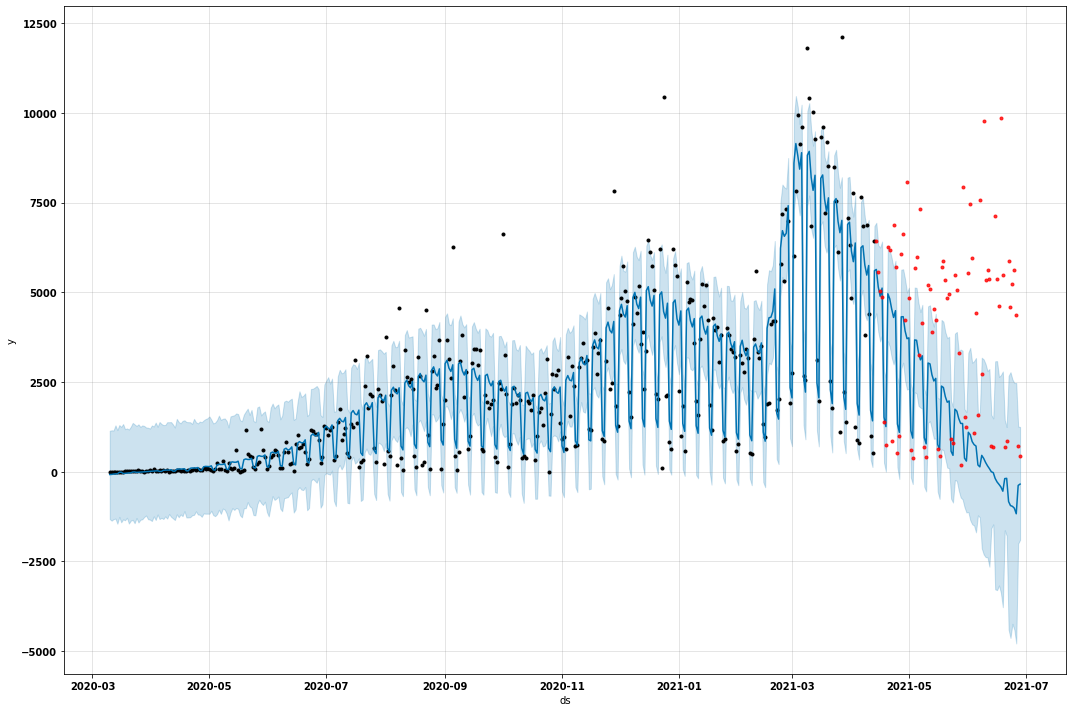

In [104]:
fig = mod_casos_estado.plot(prev_casos_estado, figsize = (15,10))
plt.plot(df_casos_teste_estado['ds'],
         df_casos_teste_estado['y'],
         '.r', alpha=0.8)
plt.show()

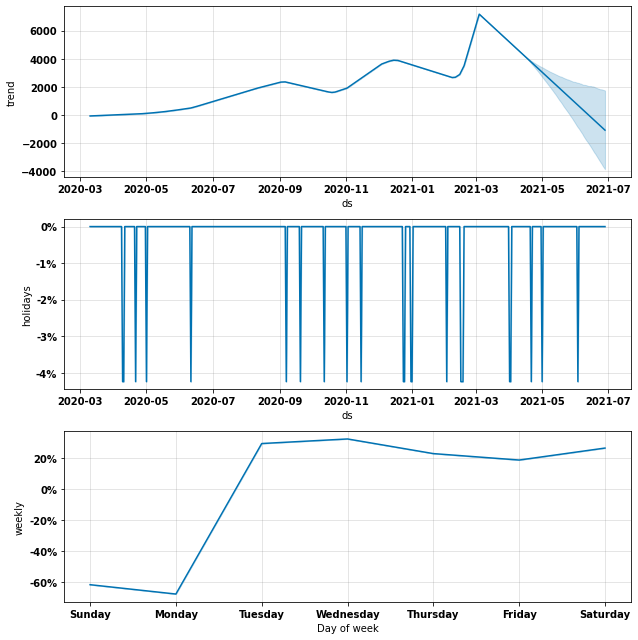

In [105]:
mod_casos_estado.plot_components(prev_casos_estado);

Podemos ver que o modelo não consegue captar a movimentação que ocorre no final da série de dados, onde tivemos uma nova onda de casos. Isso faz com que ele aplique uma tendência de baixa inclusive trazendo para o modelo uma previsão de casos negativos, o que sabemos que não pode acontecer.

Vamos ver como o modelo ficou em relação aos óbitos.

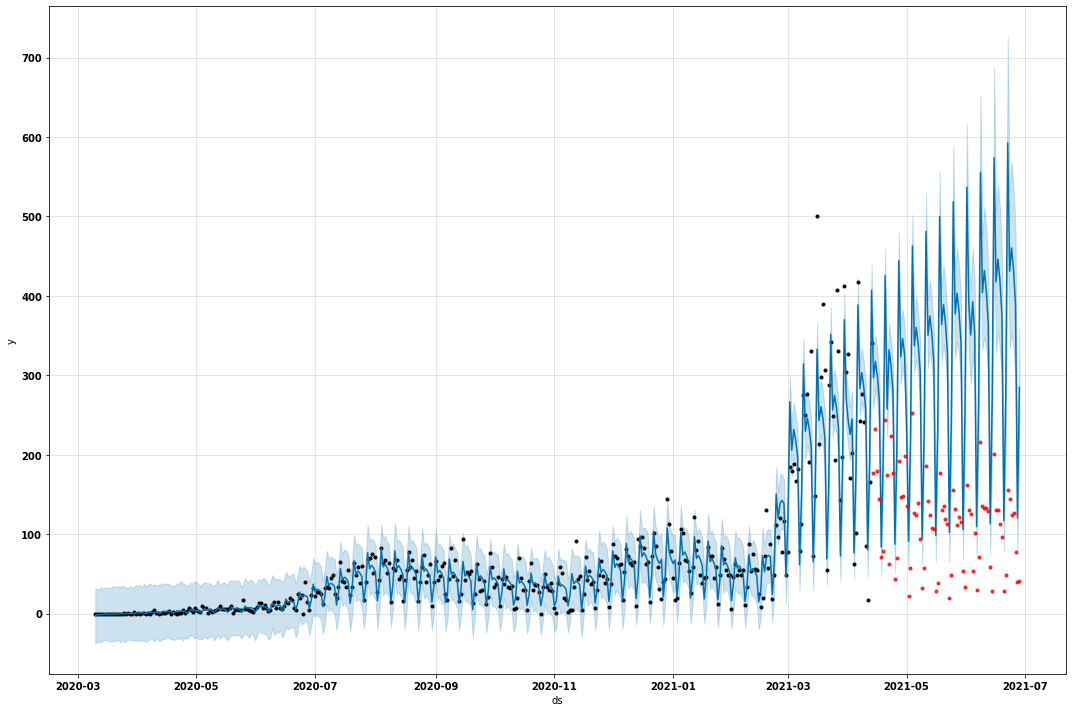

In [106]:
fig = mod_obitos_estado.plot(prev_obitos_estado, figsize = (15,10))
plt.plot(df_obitos_teste_estado['ds'],
         df_obitos_teste_estado['y'],
         '.r', alpha=0.8)
plt.show()

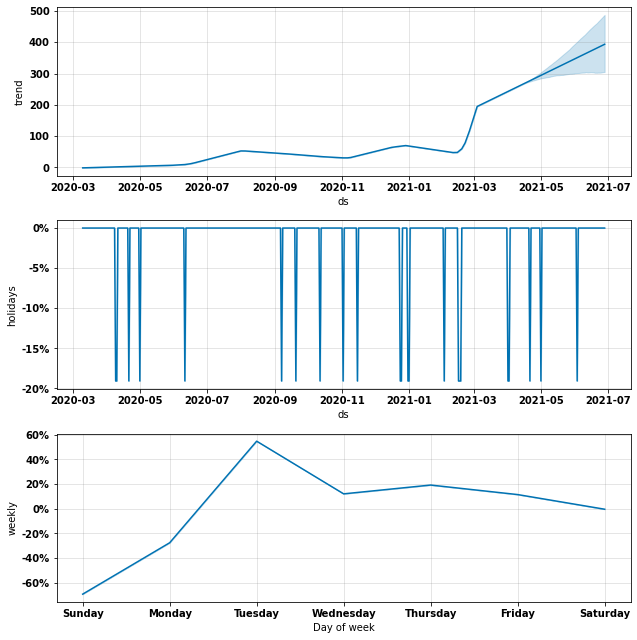

In [107]:
mod_obitos_estado.plot_components(prev_obitos_estado);

A alteração de situação que tivemos, muito provavelmente relacionada ao processo de vacinação que fez com que diminuísse a letalidade da doença, também deixa o modelo ruim para a previsão, só que nesse caso, ao contrário, prevendo mais óbitos do que efetivamente ocorreram.

çadkfçds


### **Modelo para a Cidade de Porto Alegre**
---

O modelo que apresentou o melhor equilíbrio entre os dados de teste e os dados de treino é o apresentado abaixo.



In [108]:
### Base = dados_poa
season = 'multiplicative'
growth = 'linear'
dias = 400
cps = 10
var_func = 'casos'
cpr = 0.9
n_cp = 100

(mod_casos_poa, prev_casos_poa,
 df_casos_teste_poa, mod_obitos_poa,
 prev_obitos_poa, df_obitos_teste_poa,
 perf_results) = profeta_v4(dados_poa,perf_results,
                            dias, cps = cps, var_func=var_func,
                            cpr = cpr,n_cp = n_cp, 
                            season=season, growth=growth)

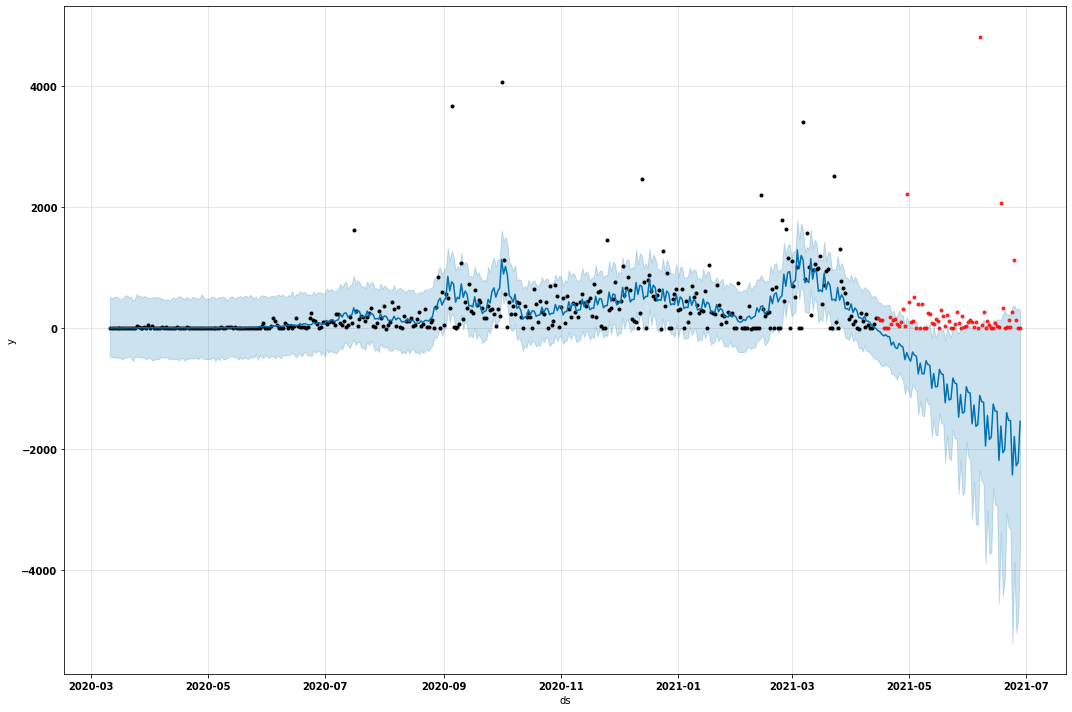

In [109]:
fig = mod_casos_poa.plot(prev_casos_poa, figsize = (15,10))
plt.plot(df_casos_teste_poa['ds'],
         df_casos_teste_poa['y'],
         '.r', alpha=0.8)
plt.show()

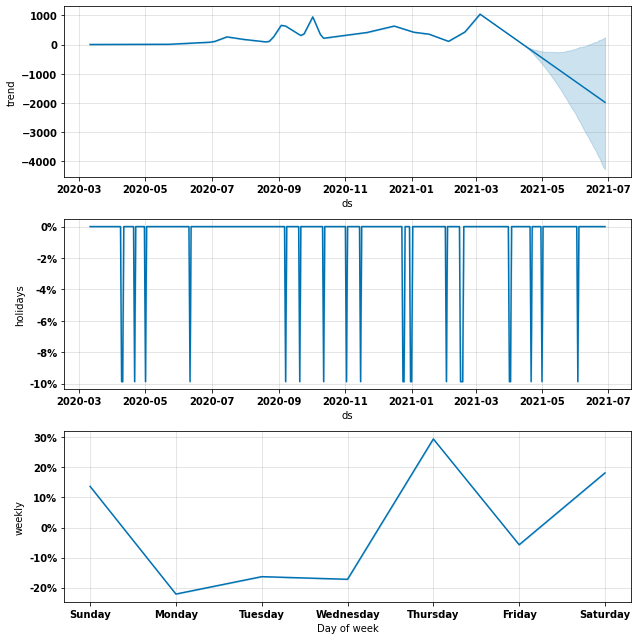

In [111]:
mod_casos_poa.plot_components(prev_casos_poa);

O melhor modelo para Porto Alegre fica ainda pior que o consolidado do Estado, apresentando uma projeção de queda acentuada que leva para valores diários negativos que não podem ocorrer.

Vamos ver como o modelo ficou em relação aos óbitos.

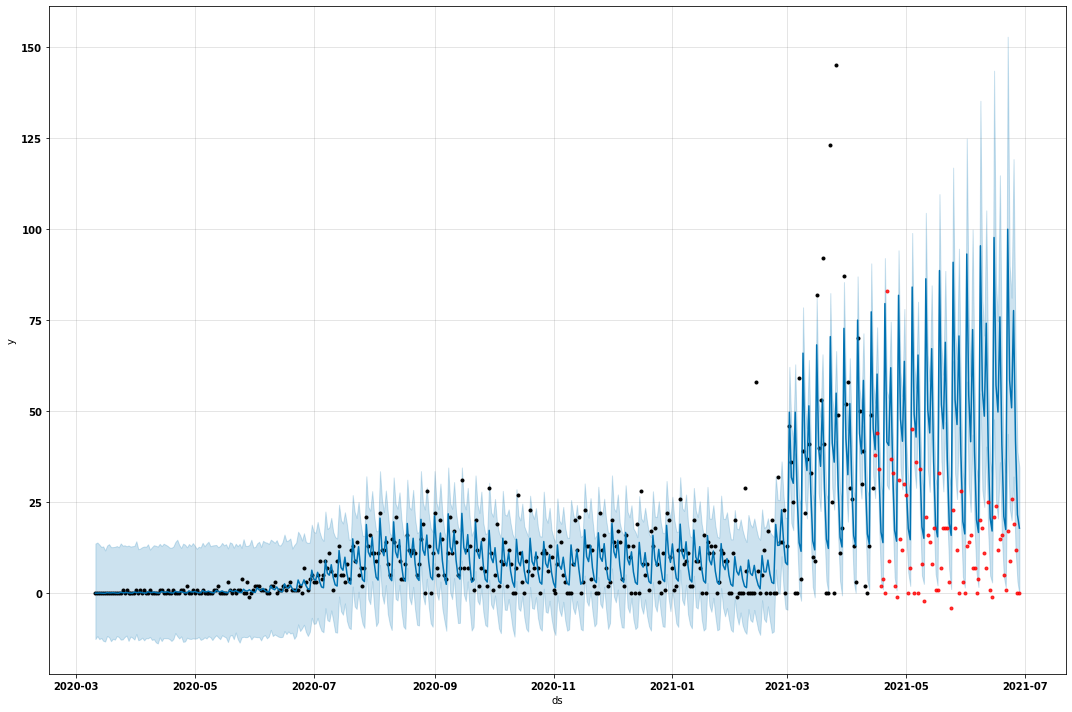

In [110]:
fig = mod_obitos_poa.plot(prev_obitos_poa, figsize = (15,10))
plt.plot(df_obitos_teste_poa['ds'],
         df_obitos_teste_poa['y'],
         '.r', alpha=0.8)
plt.show()

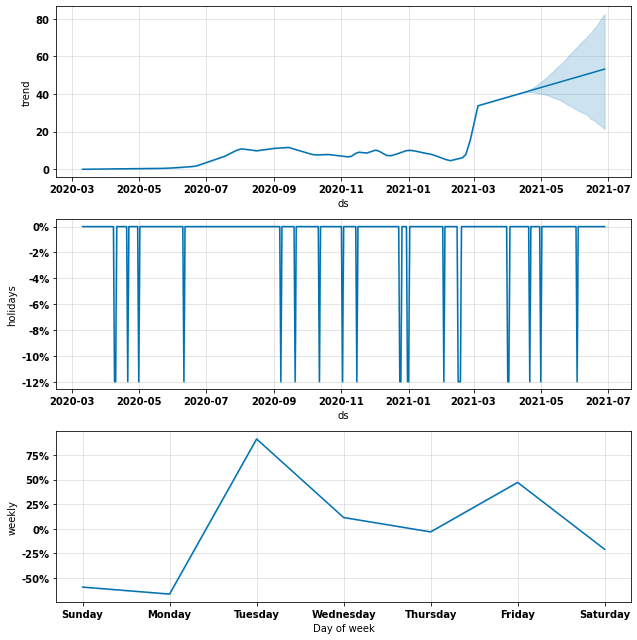

In [112]:
mod_obitos_poa.plot_components(prev_obitos_poa);

O modelo de Porto Alegre também não ficou bom para a projeção de óbitos, apesar de termos boa parte dos valores de teste dentro do intervalo de confiança da projeção.

### **Modelo para o Interior do Estado do RS**
---

O modelo que apresentou o melhor equilíbrio entre os dados de teste e os dados de treino é o apresentado abaixo.



In [118]:
### Base = dados_interior
season = 'multiplicative'
growth = 'linear'
dias = 400
cps = 10
var_func = 'casos'
cpr = 0.9
n_cp = 100

(mod_casos_interior, prev_casos_interior,
 df_casos_teste_interior, mod_obitos_interior,
 prev_obitos_interior, df_obitos_teste_interior,
 perf_results) = profeta_v4(dados_interior,perf_results,
                            dias, cps = cps, var_func=var_func,
                            cpr = cpr,n_cp = n_cp, 
                            season=season, growth=growth)

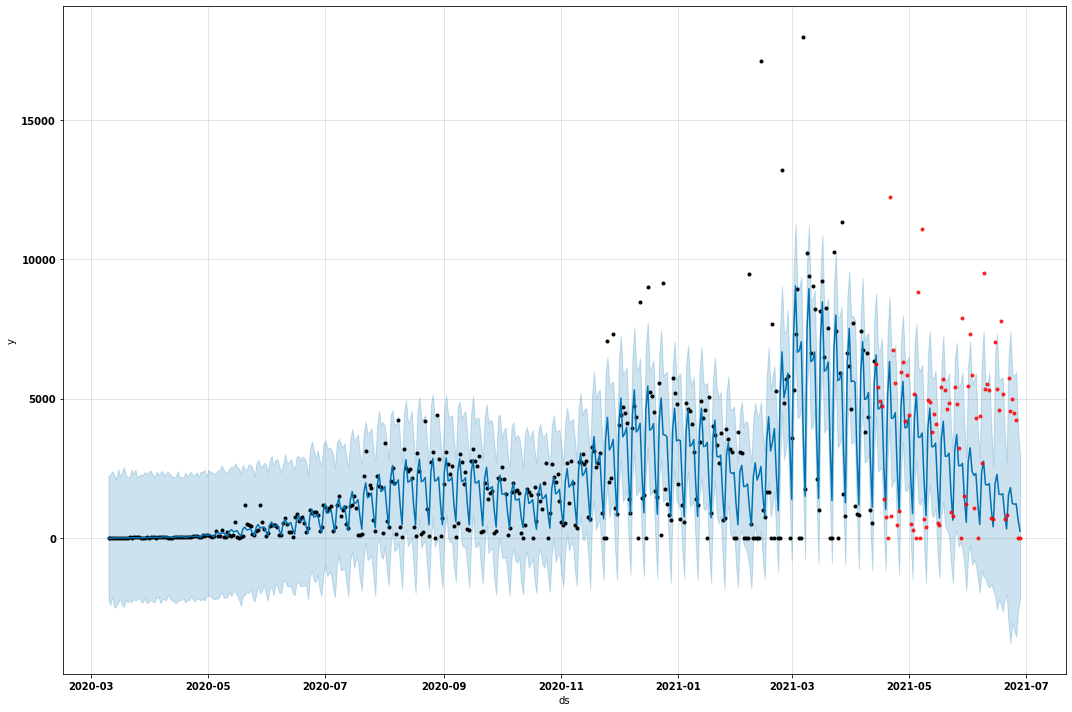

In [119]:
fig = mod_casos_interior.plot(prev_casos_interior, figsize = (15,10))
plt.plot(df_casos_teste_interior['ds'],
         df_casos_teste_interior['y'],
         '.r', alpha=0.8)
plt.show()

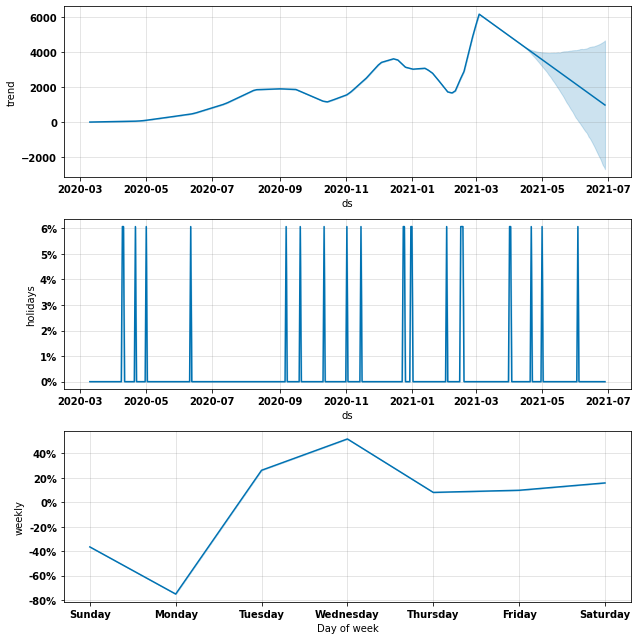

In [120]:
mod_casos_interior.plot_components(prev_casos_interior);

Podemos ver que o modelo não consegue captar a movimentação que ocorre no final da série de dados, onde tivemos uma nova onda de casos. Isso faz com que ele aplique uma tendência de baixa que não chega a apontar para a ocorrência de casos negativos como nos demais modelos, mas ainda não é um modelo bom.

Vamos ver como o modelo ficou em relação aos óbitos.

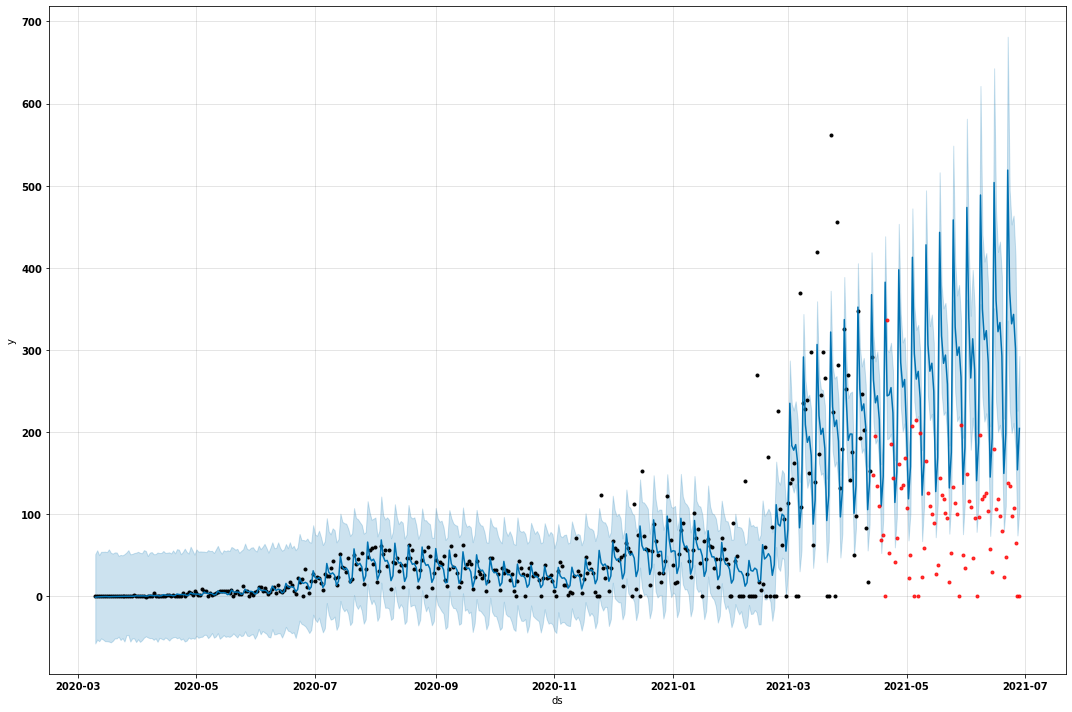

In [121]:
fig = mod_obitos_interior.plot(prev_obitos_interior, figsize = (15,10))
plt.plot(df_obitos_teste_interior['ds'],
         df_obitos_teste_interior['y'],
         '.r', alpha=0.8)
plt.show()

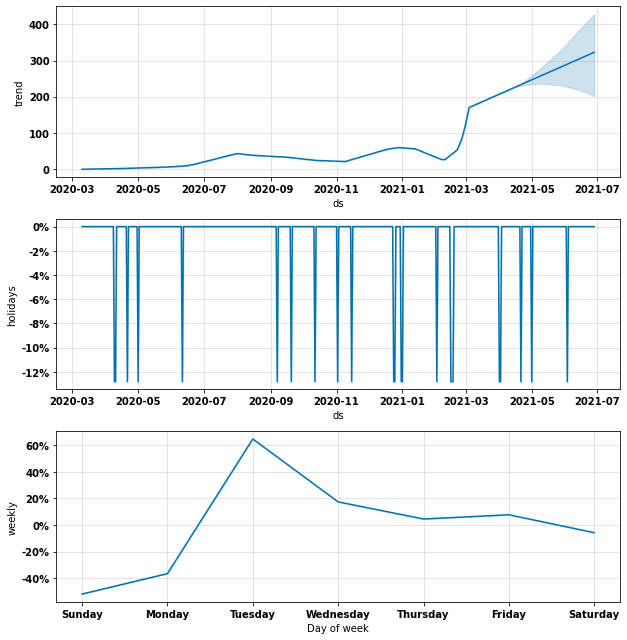

In [122]:
mod_obitos_interior.plot_components(prev_obitos_interior);

Aqui temos uma repetição dos outros modelos, com projeção de óbitos muito acima do que realmente temos em nossos dados de teste.

## **Corrigindo** ***Outliers***
---

Existem várias maneiras de se trabalhar para tentar amenizar os efeitos dos *outliers* no estudo e nas projeções.

Como percebi que tínhamos várias problemas nas bases de dados por atrasos nas notificações, gerando lançamentos acumulados que atrapalham a elaboração de um modelo e das previsões, optei por trabalhar usando a média móvel de 7 dias para os dados, o que suaviza muito as distorções trazidas por *outliers*.

Vamos ver como ficaram os modelos dessa forma.


Para poder fazer previsões precisamos elaborar um modelo preditivo que será treinado com parte dos nossos dados. Em seguida, esse modelo é testado com o restante do *dataset* para verificar sua acurácia.

Além disso, também usaremos ferramentas de validação cruzada para tentar identificar qual o horizonte de previsão que o nosso modelo vai conseguir trabalhar.

A biblioteca que usaremos para isso é a **Facebook Prophet**.

O **Prophet** é uma biblioteca criada pela divisão de pesquisa do **Facebook** e lançada em fevereiro de 2017.

É uma ferramenta *Open Source* (de código aberto, [link](https://github.com/facebook/prophet)) específica para previsões de séries temporais e está disponível para ***Python*** e ***R***, outra linguagem também muito usada para ciência de dados.

Tem uma sintaxe muito simples e intuitiva, sem por isso ser menos poderosa.

Vamos importá-la para o nosso projeto, junto com as métricas de avaliação da qualidade do modelo do próprio **Prophet** e de uma outra biblioteca, a **SciKitLearn**.

### **Modelo para o Estado Consolidado**
---

O modelo que apresentou o melhor equilíbrio entre os dados de teste e os dados de treino é o apresentado abaixo.



In [123]:
### Base = dados_estado
season = 'multiplicative'
growth = 'linear'
dias = 400
cps = 1
var_func = 'média'
cpr = 0.9
n_cp = 100

(mod_casos_estado, prev_casos_estado,
 df_casos_teste_estado, mod_obitos_estado,
 prev_obitos_estado, df_obitos_teste_estado,
 perf_results) = profeta_v4(dados_estado,perf_results,
                            dias, cps = cps, var_func=var_func,
                            cpr = cpr,n_cp = n_cp, 
                            season=season, growth=growth)

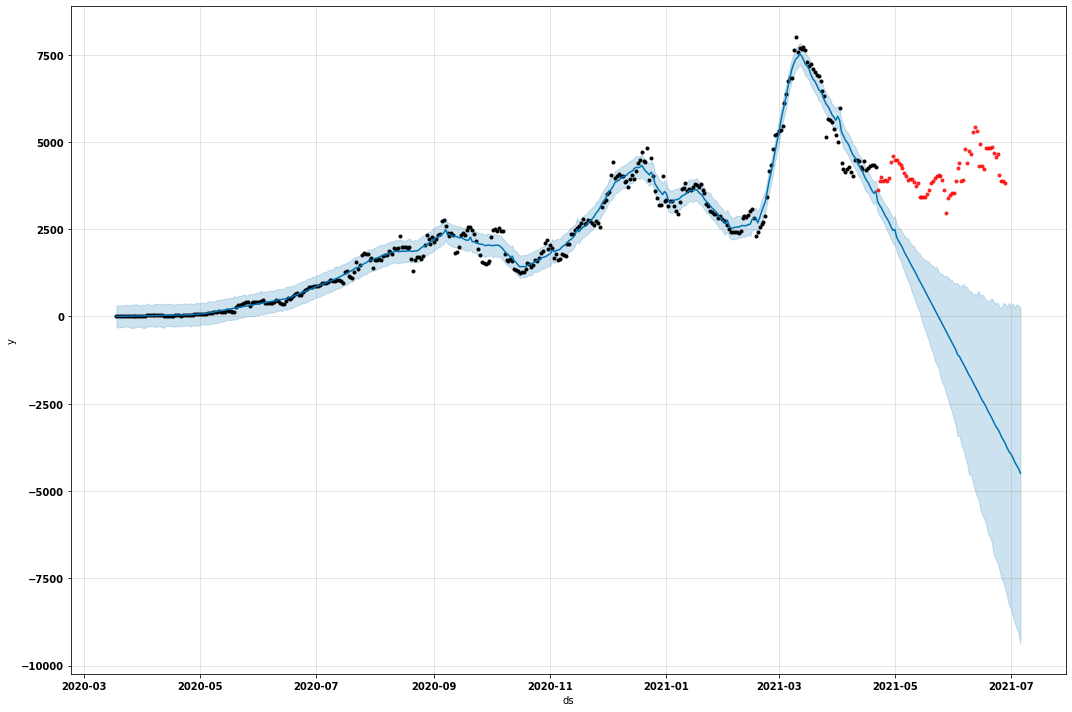

In [124]:
fig = mod_casos_estado.plot(prev_casos_estado, figsize = (15,10))
plt.plot(df_casos_teste_estado['ds'],
         df_casos_teste_estado['y'],
         '.r', alpha=0.8)
plt.show()

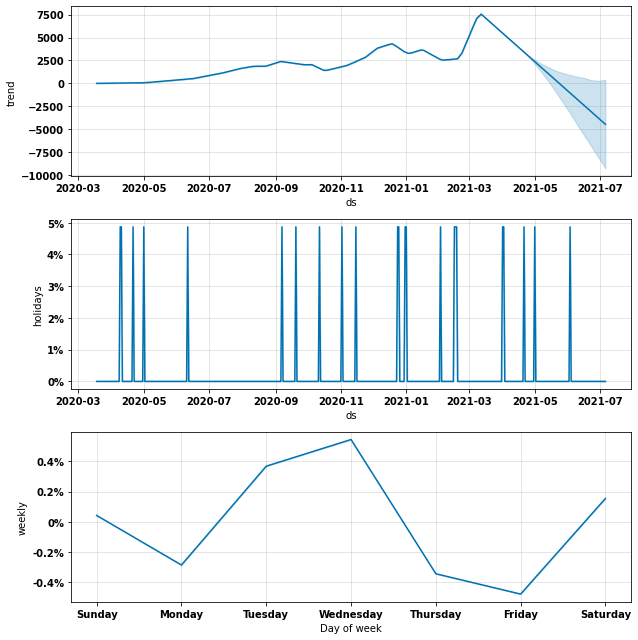

In [125]:
mod_casos_estado.plot_components(prev_casos_estado);

Apesar do modelo ficar muito melhor para os dados de treino, ele fica péssimo para a previsão... o modelo só pega a queda sem pegar o novo início de onda e deixa tudo muito distorcido.

Vamos ver como o modelo ficou em relação aos óbitos.

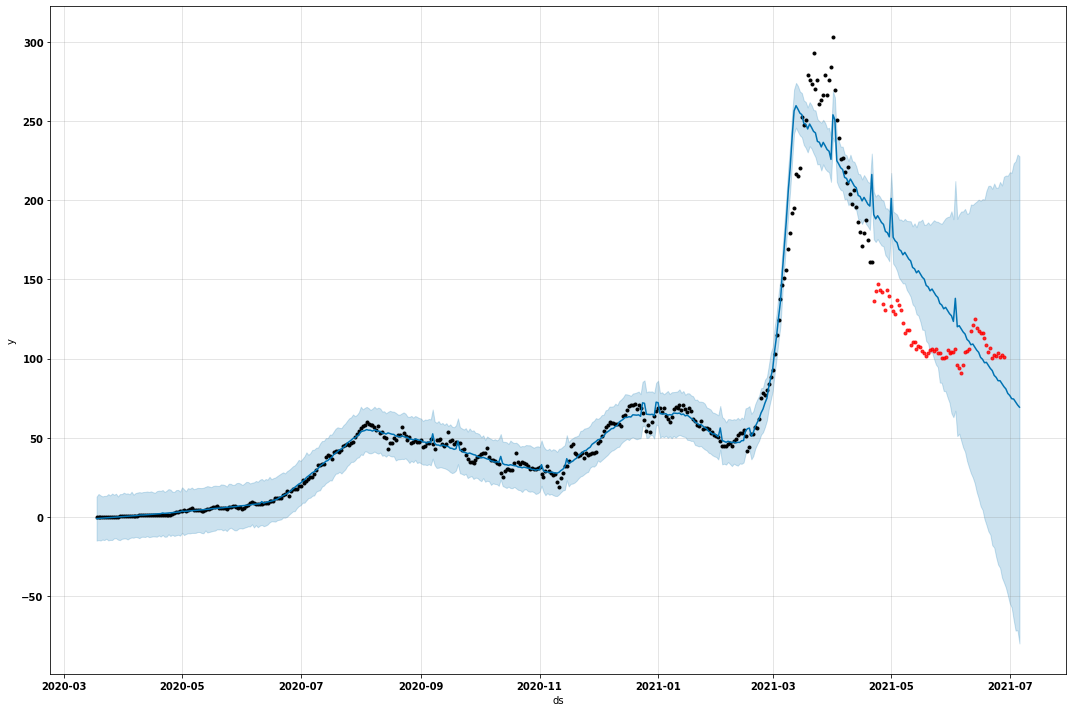

In [126]:
fig = mod_obitos_estado.plot(prev_obitos_estado, figsize = (15,10))
plt.plot(df_obitos_teste_estado['ds'],
         df_obitos_teste_estado['y'],
         '.r', alpha=0.8)
plt.show()

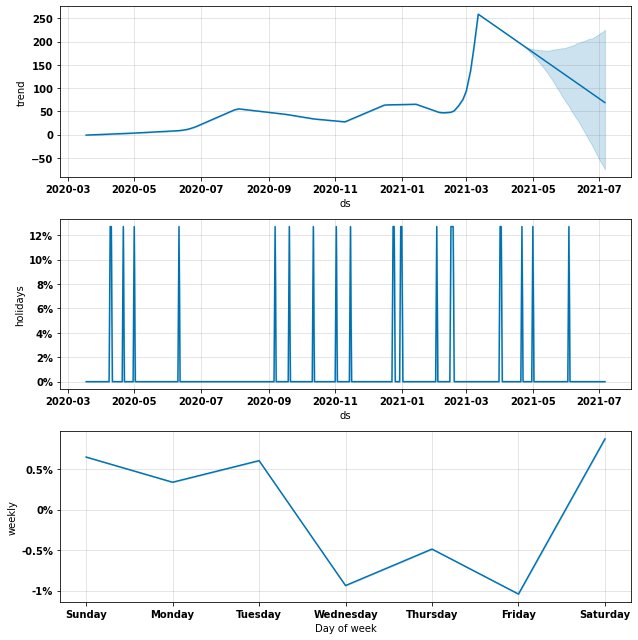

In [127]:
mod_obitos_estado.plot_components(prev_obitos_estado);

O modelo pega a tendência de queda de óbitos mas exagera na projeção, além de não capturar o início da nova onda.

### **Modelo para a Cidade de Porto Alegre**
---

O modelo que apresentou o melhor equilíbrio entre os dados de teste e os dados de treino é o apresentado abaixo.



In [128]:
### Base = dados_poa
season = 'multiplicative'
growth = 'linear'
dias = 400
cps = 10
var_func = 'média'
cpr = 0.9
n_cp = 100

(mod_casos_poa, prev_casos_poa,
 df_casos_teste_poa, mod_obitos_poa,
 prev_obitos_poa, df_obitos_teste_poa,
 perf_results) = profeta_v4(dados_poa,perf_results,
                            dias, cps = cps, var_func=var_func,
                            cpr = cpr,n_cp = n_cp, 
                            season=season, growth=growth)

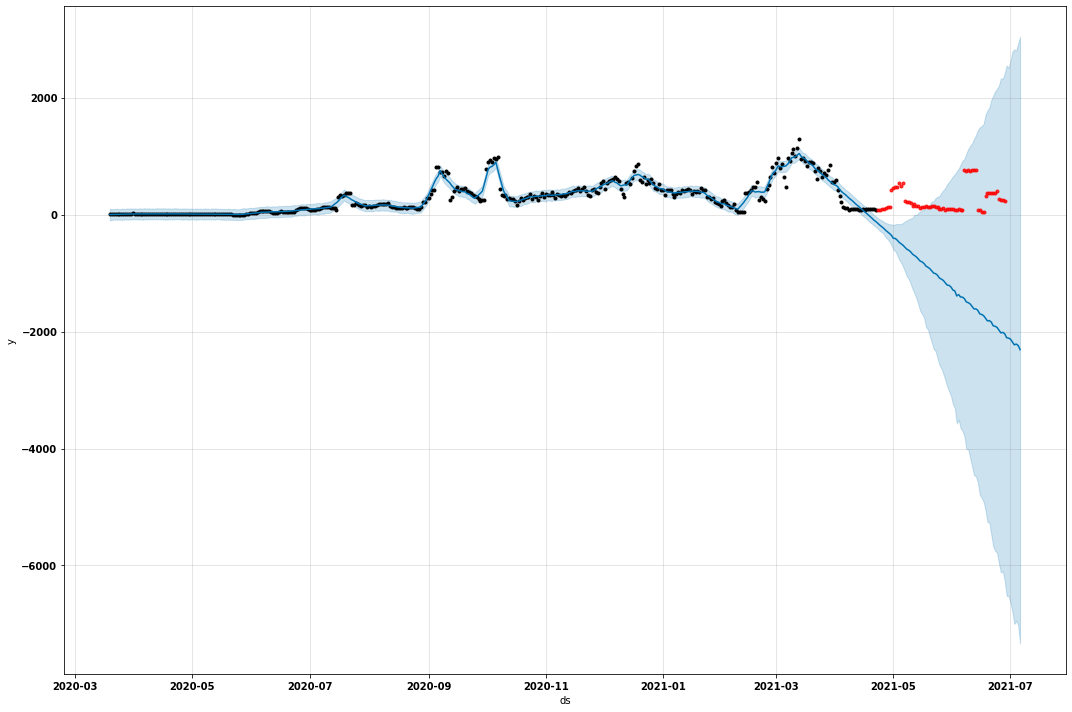

In [129]:
fig = mod_casos_poa.plot(prev_casos_poa, figsize = (15,10))
plt.plot(df_casos_teste_poa['ds'],
         df_casos_teste_poa['y'],
         '.r', alpha=0.8)
plt.show()

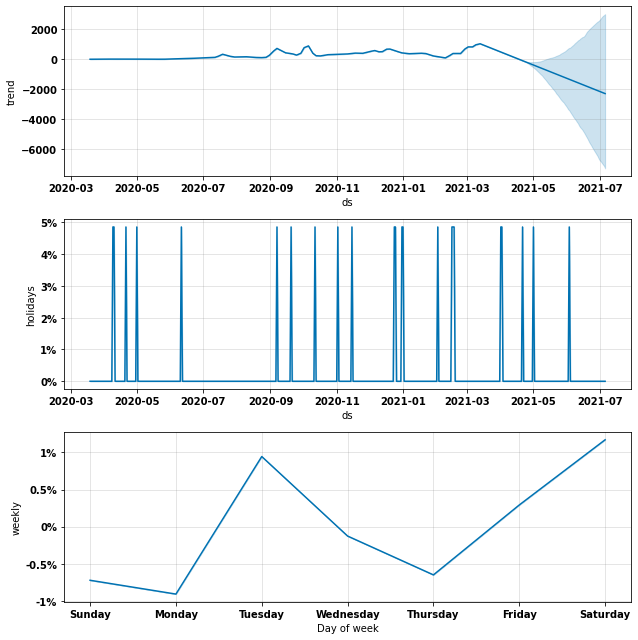

In [130]:
mod_casos_poa.plot_components(prev_casos_poa);

O melhor modelo para Porto Alegre fica ainda pior que o consolidado do Estado, com a forte queda levando para valores diários negativos que não podem ocorrer.

Vamos ver como o modelo ficou em relação aos óbitos.

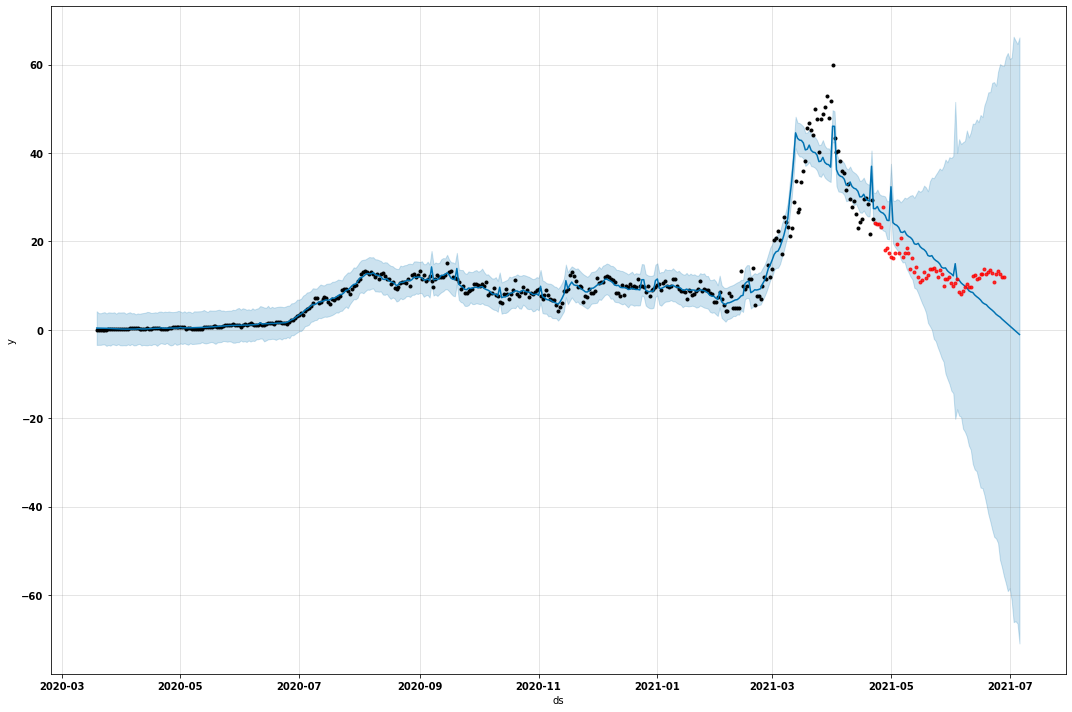

In [131]:
fig = mod_obitos_poa.plot(prev_obitos_poa, figsize = (15,10))
plt.plot(df_obitos_teste_poa['ds'],
         df_obitos_teste_poa['y'],
         '.r', alpha=0.8)
plt.show()

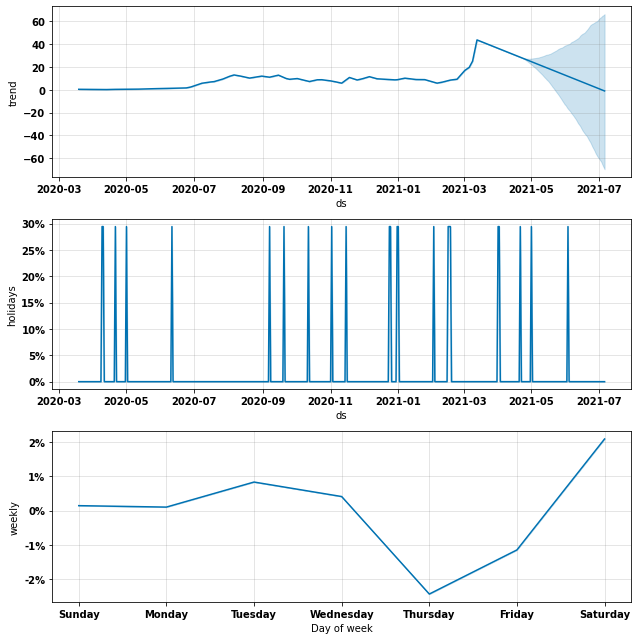

In [132]:
mod_obitos_poa.plot_components(prev_obitos_poa);

O modelo de Porto Alegre também não ficou bom para a projeção de óbitos, apesar de termos boa parte dos valores de teste dentro do intervalo de confiança da projeção.

### **Modelo para o Interior do Estado do RS**
---

O modelo que apresentou o melhor equilíbrio entre os dados de teste e os dados de treino é o apresentado abaixo.



In [133]:
### Base = dados_interior
season = 'multiplicative'
growth = 'linear'
dias = 400
cps = 10
var_func = 'média'
cpr = 0.9
n_cp = 100

(mod_casos_interior, prev_casos_interior,
 df_casos_teste_interior, mod_obitos_interior,
 prev_obitos_interior, df_obitos_teste_interior,
 perf_results) = profeta_v4(dados_interior,perf_results,
                            dias, cps = cps, var_func=var_func,
                            cpr = cpr,n_cp = n_cp, 
                            season=season, growth=growth)

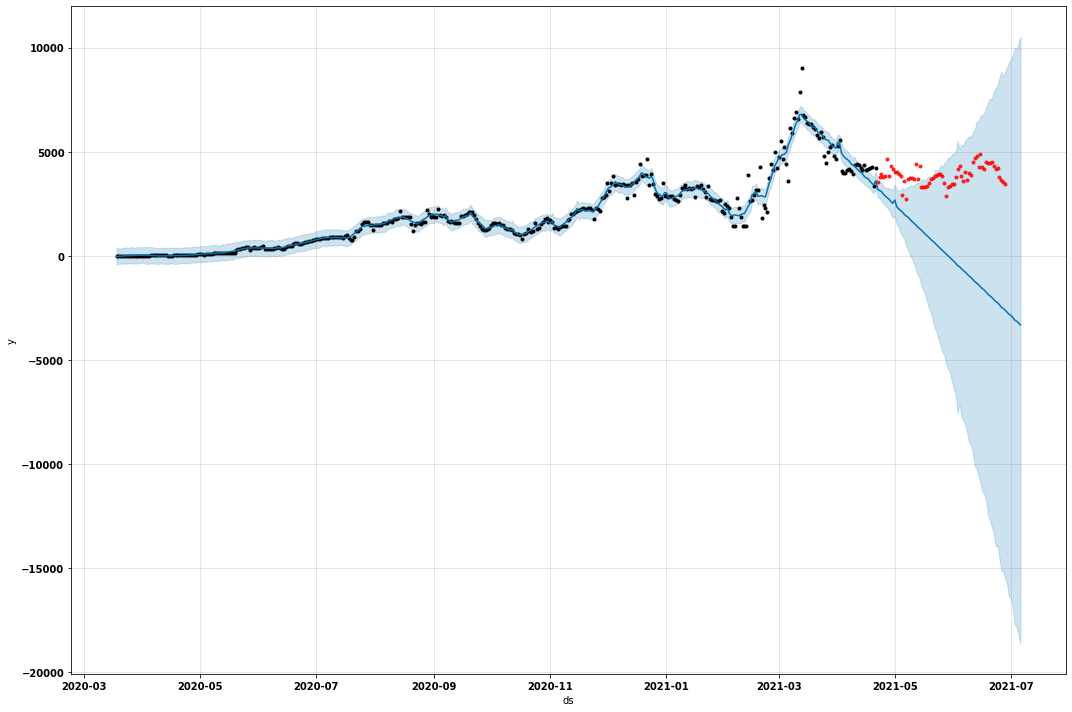

In [134]:
fig = mod_casos_interior.plot(prev_casos_interior, figsize = (15,10))
plt.plot(df_casos_teste_interior['ds'],
         df_casos_teste_interior['y'],
         '.r', alpha=0.8)
plt.show()

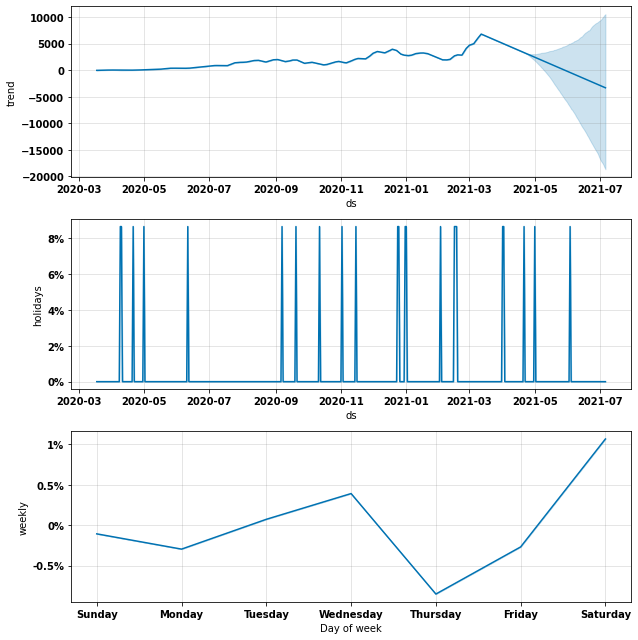

In [135]:
mod_casos_interior.plot_components(prev_casos_interior);

O modelo fica bom para os dados de treino mas muito ruim para os dados de teste, também não capta o início da nova onda e não consegue prever o novo aumento de casos.

Vamos ver como o modelo ficou em relação aos óbitos.

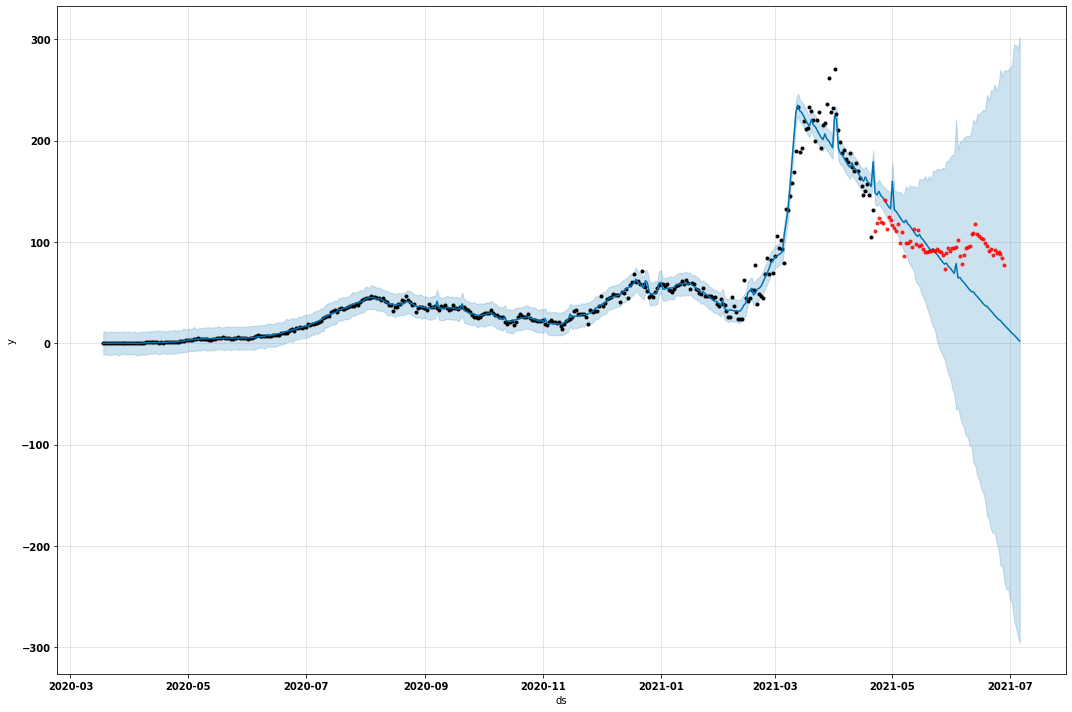

In [136]:
fig = mod_obitos_interior.plot(prev_obitos_interior, figsize = (15,10))
plt.plot(df_obitos_teste_interior['ds'],
         df_obitos_teste_interior['y'],
         '.r', alpha=0.8)
plt.show()

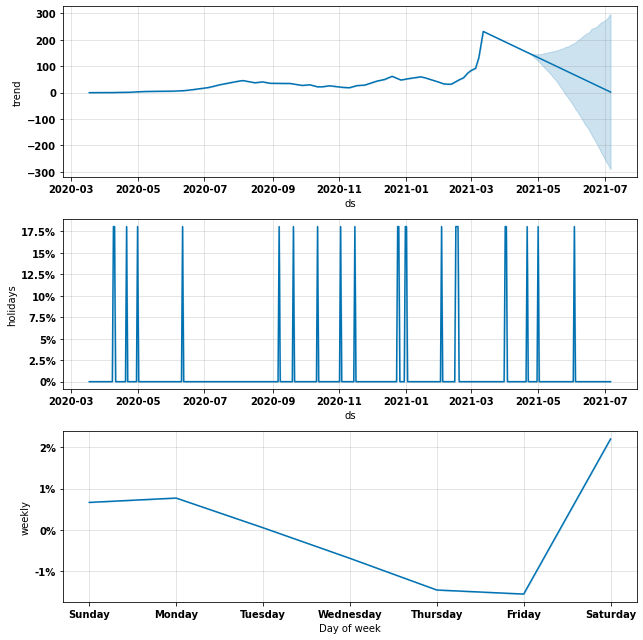

In [137]:
mod_obitos_interior.plot_components(prev_obitos_interior);

O erro de projeção também leva para a projeção da ocorrência de óbitos negativos, que não poderia prever no modelo.

## **Conclusões**
---

Acredito que o presente estudo não conseguiu chegar a um bom modelo preditivo, que era uma das propostas iniciais.

Chegamos a conseguir modelos que tiveram boa aderência aos dados de treino mas não tivemos boas projeções. Acredito que a principal razão disso foi o fato de que tivemos o início de uma nova onda de casos justamente no limite entre nossos dados de treino e teste.

Se aumentássemos os dados de treino para contemplar essa nova onda, teríamos pouquíssimos dados para testar o modelo. Entendo que precisamos revisar os modelos trabalhados dentro de um prazo mínimo de 30 dias para tentar identificar modelos que tenham condições de fazer melhores projeções.

Em relação às demais análises que haviam sido propostas:

* **Temos similaridade de comportamento entre a Capital e o Interior?**
> Ao longo do estudo identificamos que o comportamento de casos novos e de óbitos em Porto Alegre não é idêntico ao consolidado dos municípios do Interior, apresentando diversas variações.

* **Temos correlação entre as curvas de surgimento de casos novos e óbitos?**
> Em nenhum dos *datasets* foi encontrada uma correlação forte e consistente entre essas variáveis.


## **Documentação**
---

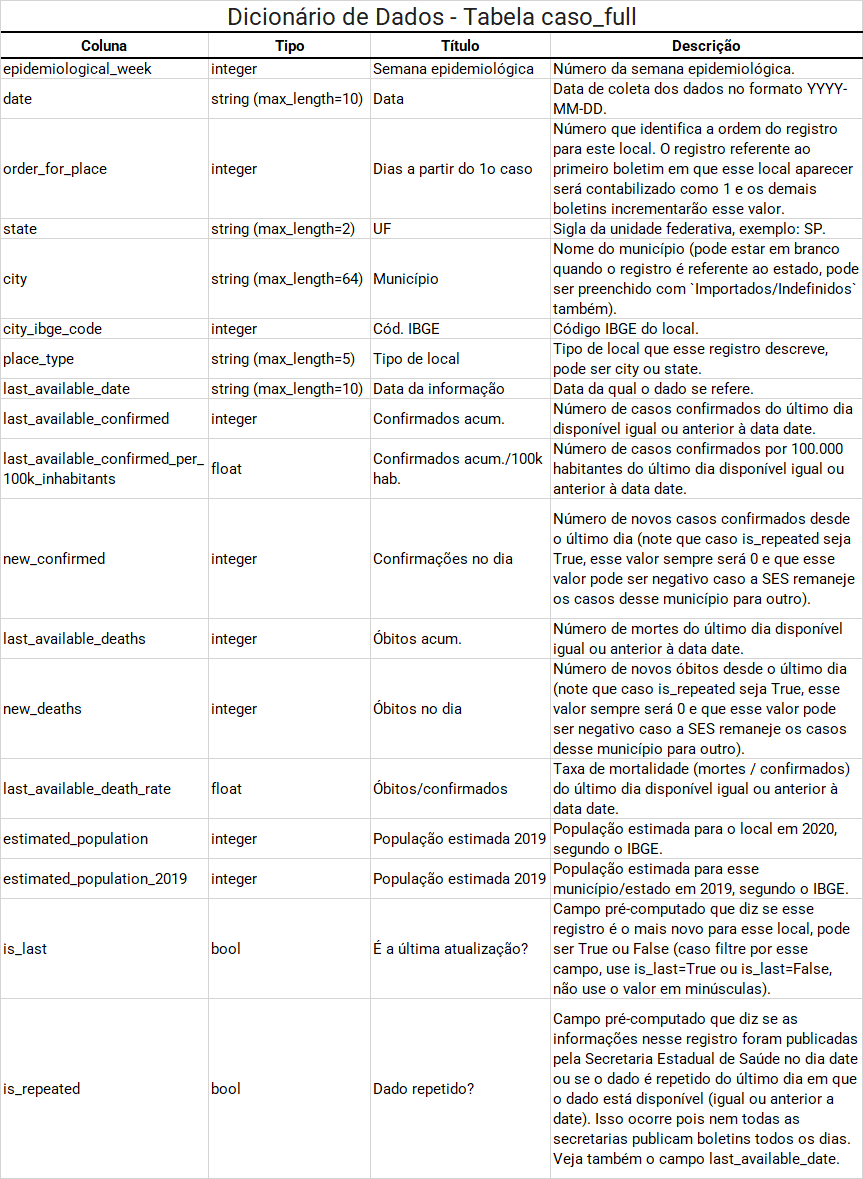

[Fonte do Dicionário de Dados](https://brasil.io/dataset/covid19/caso_full/#metadata)

Boas vindas ao Projeto do Módulo 03! Neste projeto queremos que você aplique tudo que aprendeu no curso, analisando a base de dados disponibilizada. Essa base dados foi extraída do Brasil.io e representa os casos de covid no Brasil todo. Essa base contém o número de casos novos de covid, número de óbitos e outras informações.

Utilizando mais dados, teremos mais possibilidades de análise, por exemplo, podemos mostrar os efeitos da semana epidemiológica em cada estado separadamente. Assim, explore o máximo que conseguir dos dados e nos conte suas hipóteses e suas análises através desse projeto. Porém, o objetivo principal deste módulo é a previsão de dados de séries temporais. Você pode escolher analisar um estado ou município de sua preferência ou também focar no número de casos ou óbitos.

Seguem algumas dicas para você mandar bem no desafio final do módulo: capriche nas análises, escreva suas conclusões e hipóteses (mesmo que o resultado seja inconclusivo) e não esqueça de colocar um resumo dos pontos que julgar mais interessantes do seu projeto. Pode também utilizar outros dados como, por exemplo, os disponíveis no Brasil.IO para incrementar sua análise.

Temos um conjunto de dicas para este projeto. Portanto, fique de boa, use elas como um guia para a construção da sua pesquisa e mergulhe fundo!

São boas práticas de projeto:

* Delimitar o escopo do projeto de acordo com o tempo e o aprendizado desse módulo;
* Utilizar a base de dados sugerida;
* Estruturar o projeto de maneira organizada e lógica;
* Criar um notebook que tenha um enredo atraente e coerente;
* Tratar e descrever seus dados, quando necessário;
* Fundamentar bem o cruzamento dos dados se você utilizar outras bases;
* Aplicar as técnicas de configurações de gráficos para torná-los compreensíveis e para criar argumentações embasadas neles;
* Se possível, fazer pesquisas para ir além do apresentado no módulo;
* Fazer uma conclusão que relate as limitações do projeto, dando ideias para projetos futuros e apresentando os principais resultados da análise;
* Citar e trazer as fontes de todo o conteúdo que apresentar e não for de sua autoria.